# VP-search trees for cgMLST sequences
**Author:** Johan
**Date:** 2024-09-24

# Project at SSI

The goal of this assignment is to determine if it is possible to optimize in-range searches for cgMLST profiles when extracting similar points from a database. The aim is to minimize time while also considering the added complexity of the new method in terms of increased codebase and maintenance costs associated with the chosen data structure.

The Searches:
A user provides a cgMLST sequence and a maximum allowed difference. The objective is to find all points in the database with a difference smaller than the specified maximum difference.

The difference between two cgMLST sequences is measured using the Hamming distance, with slight modifications to how missing values are handled.

Most, if not all, sequences in the database contain missing values in one or more instances.





# Theory
The in-range problem bears some resemblance to a Nearest Neighbor Search (NNS).

VP-trees allow for fast NNS and in-range searches in generalized metric spaces. I found a really nice article on this topic:

Data Structures and Algorithms for Nearest Neighbor Search in General Metric Spaces by Peter N. Yianilos.

https://dl.acm.org/doi/10.5555/313559.313789

The VP-tree requires a metric space, and the entire concept is built around the triangle inequality. Therefore, this property is essential for the method to work.




## Metric Space

A metric space is a space with a well-defined distance function.

Start by defining a distance.  
Let $(a,b)$ be points in the space, $( a, b \in \mathcal{S} )$.

A function $d(a, b)$ is a distance if it satisfies the following properties:

1) $d(a,b)=0$

2) $d(a,b)>0$ if $x\neq y$  Note: This does not hold in pseudo-metric spaces

3) $d(a,b)=d(a,b)$ symmetry 

4) $d(a,b) \geq d(a,z)+d(z,b)$ Triangle inequality


In the article, they use a bounded metric space, meaning $d(x, y) \in [0, 1]$, and they point out that one can always construct a bounded space.

Let $p$ be a chosen element in $\mathcal{S}$. Define the following:

$\Pi_p(a) = d(a, p)$

Now, define:

$d_p(a, b) = |\Pi_p(a) - \Pi_p(b)| = |d(a, p) - d(b, p)|$

This is simply the absolute value of the difference in distance from $a$ to $p$ and from $p$ to $b$.

If $d_p(a, b) \geq \tau $, then $ d(a, b) \geq \tau $. 

This is the reverse triangle inequality for metric spaces.

https://en.wikipedia.org/wiki/Triangle_inequality#Reverse_triangle_inequality

### Small note

Remember that a point in a ball is defined as all points having a distance smaller than a set value \( r \) to the center:

$B_r[c] = \{y \in \mathcal{S} \mid d(y, c) < r \}$

where $ \mathcal{S} $ is the space.

This is just a generalized definition of the ball, meaning it works with all distances. For example, in the case of the first norm, the ball is diamond-shaped, illustrating that shapes can differ for different distance metrics.

This note is provided in case the reader is not familiar with measure theory.


## Hamming distance

The Hamming distance can be defined as follows:

Let $X=\{x_1,\dots,x_N\}$ and $Y=\{y_1,\dots,y_N\}$.
where $X$ and $Y$ are sequences of equal size.

The Hamming distance distance $d_H(x,y)$

$$d_H(x,y)=\sum_{i=1}^{N}\mathbb{1}_{\{x_i\neq y_i\}}(x_i,y_i)$$

If one treat missing value(None) as charters $d_H(x,y)$ is a valid measure.
Meaning it follow the definition of a distance measure.

If one treats missing values (None) as characters, $d_H(x,y)$ remains a valid measure. This means it adheres to the definition of a distance measure.


### Handeling of missing values.
Missing values can be represented with the type $None$ in Python, and as a consequence, when writing about the value of an entry not being present, it will be referred to as $None$.

When performing cgMLST searches, missing values are handled in two ways:

1. If one element's entry is $None$, it is considered a "match" regardless of what the other input element is. We refer to this method of measuring difference/distance as:
$$d_{H:None\ match}(x,y)$$

Using indicator funtion this can written
$$d_{H:None\ match}(x,y)=\sum_{i=1}^{N}\mathbb{1}_{\{x_i\neq y_i\}}(x_i,y_i) -\mathbb{1}_{\{x_i=None\lor y_i= None\}}(x_i,y_i) + \mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)$$


2. The other option for handling an entry of $None$ is to treat it as a mismatch, regardless of the value of the other entry. We refer to this method of measuring difference/distance as:
$$d_{H:match}(x,y)$$

Using indicator funtion this can written
$$d_{H:match}(x,y)=\sum_{i=1}^{N}\mathbb{1}_{\{x_i \neq y_i\}}(x_i,y_i)-\mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)$$

#### Some examples
Below is some simple examples to ilustrat the different measures


$v_1 =c(1,2,3,4)$

$v_2 =c(1,1,4,3)$

$v_3 =c(1,None,4,3)$

$v_4= c(2,None,2,None)$

$d_H(v_1,v_2)=3$,
$d_H(v_1,v_3)=3$,
$d_H(v_3,v_4)=3$ and 
$d_H(v_4,v_4)=0$

$d_{H:None\ match}(v_1,v_2)=3$,
$d_{H:None\ match}(v_1,v_3)=3$,
$d_{H:None\ match}(v_3,v_4)=2$ and 
$d_{H:None\ match}(v_4,v_4)=0$

$d_{H:Match}(v_1,v_2)=3$,
$d_{H:Match}(v_1,v_3)=3$,
$d_{H:Match}(v_3,v_4)=2$ and 
$d_{H:Match}(v_4,v_4)=2$ 


#### A few thing to note.
With no missing values $None$ pressent, all methods give the same values. This means that if no $None$ values are present, 
$d_{H:Match}(x, y)$ and $d_{H:None\ match}(x, y)$ correspond to $d_H(x, y)$ is a valid distance measure.


Unfortunately, when $None$ values are present, $d_{H:Match}(x, y)$ and $d_{H:None\ match}(x, y)$ do not satisfy the definition of a distance.

see that:

$d_{H:Match}(v_4, v_4) = 2 \neq 0$

This shows that $d_{H:Match}$ does not measure the distance to the point itself as zero, violating one of the properties of a distance metric.

Additionally, $d_{H:None\ match}(x, y)$ breaks the triangle inequality.

Look at the following example.

$$a= c(1,     None,   8,  8,  9,        2)$$

$$b= c(None,  1,     8,   7,  7,       5)$$

$$c= c(1,     1,     8,   8,  None,   None)$$

Gives the distance
$$d_{H:None\ match}(a,b)= 4$$ 
$$d_{H:None\ match}(a,c)= 1$$
$$d_{H:None\ match} (b,c)=1$$ 

This means that:

$d_{H:None\ match}(a, b) \geq d_{H:None\ match}(a, c) + d_{None\ match}(b, c)$

Thus, the triangle inequality is broken, meaning there is a shorter distance between two points through a third point.

The method used for searching in this project (VP-tree) requires points to reside in a metric space.

Since many points in the database have missing values, they cannot simply be disregarded. It is an important aspect of the solution that it can handle this method of dealing with missing values.





## The smallest ball

The idea is to find a ball based on the Hamming distance 
$d_H(x,y)$ that contains all the points of interest. Specifically, if a user specifies a maximum distance $R_max$ and a query point $q$, along with a method, either 
$d_{H:None\ match}(x,y)$ or $d_{H:Match}(x,y)$ the goal is to find the corresponding ball.

Formally, the user specifies a ball based on the distance, which can be either:

$$ B_{R_{max}}[q]=\{y\in \mathcal{S} | d_{H:None\ match}(y,q) < R_{max} \}$$

or

$$ B_{R_{max}}[q]=\{y\in \mathcal{S} | d_{H:Match}(y,q) < R_{max} \}$$

The user is interested in the set:

$\{y | y \in B_{R_{max}}[q]\}$

To create a new ball based on the Hamming distance with a new radius R_{max\ H}, we define:

$$B_{R_{max\ H}}[q]=\{y\in \mathcal{S} | d_{H}(y,q) < R_{max\ H} \}$$

Let the output set of this be:

$\{z | z \in B_{R_{max\ H}}[q]\}$

The goal is to find the smallest value of $R_{max\ H}$ such that:

$$\{y | y \in B_{R_{max}}[q]\}  \subseteq \{z | z \in B_{R_{max\ H}}[q]\}$$

Since the query point $q$ is the same, this problem simplifies to ensuring that 

$d_H(x,y)$ is always larger than d_{H:None\ match}(y,q) and $d_{H:Match}(x,y)$ 



## Formal bounds

In this section formal bounds for the diffrence between the Haming distnace and the custom distance $d_{H:None\ match}$ and $d_{H:Match}$ is derived.



### $d_{H:None\ match}(x,y)$

The difference between the Hamming distance $d_{H}(x,y)$ and d_{H:None\ match}
can be expressed as:

$$d_{H}(x,y)-d_{H:None\ match}(x,y)=\sum_{i=1}^{N}\mathbb{1}_{\{x_i\neq y_i\}}(x_i,y_i)\\ -\sum_{i=1}^{N}\mathbb{1}_{\{x_i=y_i\}}(x_i,y_i) -\mathbb{1}_{\{x_i=None\lor y_i= None\}}(x_i,y_i)+ \mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)\\
=\sum_{i=1}^{N}+\mathbb{1}_{\{x_i=None\lor y_i= None\}}(x_i,y_i)- \mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)$$

Since the expression $\mathbb{1}_{\{x_i=None\lor y_i= None\}}(x_i,y_i)- \mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)$ is zero if both  $x_i$, $y_i$ is None, but 1 if only one of $x_i$ ore $y_i$ is None, the diffrence $d_{H}(x,y)-d_{H:None\ match}(x,y)$ represents the number of positions where $x_i$ and $y_i$ are not both None.
It is clear that $d_{H}(x,y)>d_{H:None\ match}(x,y)$ since the exprsion is allway posetiv. 
$N_{None:x}$ is the number of None elements in x and $N_{None:y}$
​is the number of None elements in y, then:

$$d_{H}(x,y)-d_{H:None\ match}(x,y)\leq N_{None:x}+N_{None:y}$$
This is because the maximum number of non-matching positions involving None values is bounded by the total number of None values in $x$ and $y$


### Small Example

Consider the following vectors:

$vec1=c(None,   None,   1,      2,      3)$

$vec2=c(2,      1,      None,   None,   None)$

$vec3=c(2,      None,   None,   None,   3)$

The difference $d_{H}(vec1,vec2)-d_{H:None\ match}(vec1,vec2)=5$ represents the worst case where none of the None values align in the same positions.

On the other hand, $d_{H}(vec2,vec3)-d_{H:None\ match}(vec1,vec2)=4$ is a smaller difference where there is one matching None.

A small but important note is that if $N_{None:x}+N_{None:y}<N$, where $N$ is the length of $x$ or $y$, the bound still holds but the upper limit should be adjusted to $min\{N_{None:x}+N_{None:y},N\}$. Beyond this limit, the bound becomes less useful for searching purposes.

Conclusion:

$$d_{H:None\ match}(x,y)\leq d_{H}(x,y)\leq d_{H:None\ match}(x,y) + N_{None:x}+N_{None:y}$$


### $d_{H:Match}(x,y)$


The difference between the Hamming distance $d_{H}(x,y)$ and $d_{H:Match}(x,y)$ is given by:

$$d_H(x,y)-d_{H:Match}(x,y)=\sum_{i=1}^{N}\mathbb{1}_{\{x_i\neq y_i\}}(x_i,y_i)- \sum_{i=1}^{N}\mathbb{1}_{\{x_i \neq y_i\}}(x_i,y_i)-\mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)=\sum_{i=1}^{N}\mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)$$

The term $\mathbb{1}_{\{x_i=None,y_i= None\}}(x_i,y_i)$ contributes 1 only if both x_i and y_i are None.
Thus $d_H(x,y)-d_{H:Match}$ is always non-negative, meaning that $d_H(x,y)$ is always greater than or equal to
$d_{H:Match}(x,y)$

This difference is limited by $min\{N_\{None:x,None:y\}\}$ which represents the maximum number of positions where both $x_i$ and $y_i$ can be None simultaneously.



### Small exampel here

Consider the following vectors:


$vec1=c(None,   None,   1,      2,      3)$

$vec2=c( None,   None,   None,  2,      3)$

$vec3=c(2,      None,   None,   None,   3)$

Calculate the differences:

$d_H(vec1,vec2)-d_{H:Match}(vec1,vec)=1$

$d_H(vec2,vec3)-d_{H:Match}(vec2,vec3)=2$


Conclusion :

$$d_{H:Match}(x,y)\leq d_{H}(x,y)\leq d_{H:Match}(x,y) + min\{N_{None:x},N_{None:y}\}$$



### Small illustration.
I made a small illustration of the different balls.

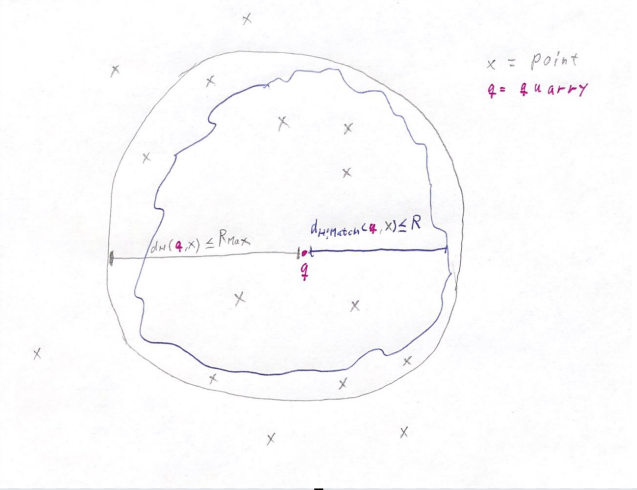

## VP-Tree Search with Hamming Distance and Post-Processing
The idea is to use the in-range search in the VP-tree with the correct Hamming distance $d_H(x,y)$, since it is a well-defined measure. The points of interest are based on $d_{H:Match}$ and 
$d_{H:None\ match}$ , so the radius needs to be adjusted accordingly, which may lead to some false positives. This means the method will return points with larger $d_{H:None\ match}$ and $d_H:Match$ values than the user initially specified. By adding a post-processing step where these points are filtered out, the false positives will be removed.

The advantage of this approach is that it leverages the speed of the VP-tree while still ensuring all correct values are returned.

Let the point of interest be called the query point (q) and let Points be the points in the database.

Let $N_{q:None}$ be the number of None values in $q$ and let $N_{Max\ None:Points}$ be the largest count of Nones found in the points. If the user sets the maximum distance based on $d_{H:None\ match}$, the distance in the VP search should be $d_{H:None\ match}+N_{q:None}+N_{Max\ None:Points}$. 

If the user sets the maximum distance based on $d_{H:Match}$, the distance in the VP search should be 
$d_{H:Match}+min \{ N_q+N_{Max\ None:Points} \}$

The post-processing involves checking each point to see if it satisfies the conditions 
$d_{H:Match}<max\ dist$, or $d_{H:None\ match}<max\ dist$-
for all $p$ in the set of points. I refer to this as the "*Naive method*".


### Remarks

Since the search distance is influenced by $N_q$ and $N_{N:Max\ None}$, it also affects response time. A larger maximum distance in the VP-tree's range search reduces the method's ability to reject irrelevant points, resulting in less efficient searches. Moreover, it may produce more false positives, increasing post-processing time.

If $N_q$ and $N_{N:Max\ None}$ become excessively large, it might be faster to use the Naive search method instead of the VP-tree.

There are two approaches to address this issue:

1) High $N_q$ Values: If the user provides a query with a very high $N_q$, the Naive method can be employed directly, bypassing the VP-tree. This adjustment is usually manageable since it only affects the current search.

2) High $N_{Max\ None}$ Values: A small number of points with a high amount of None values can result in a $N_{Max\ None}$ significantly slowing down the search process. If this occurs, you can isolate these points by placing them into a separate list, referred to as the "*Outlier None List*". The Naive method can then be applied to this list during the post-processing step
​
A straightforward method to identify a small number of points with large $N_{None:P}$
values across the entire dataset is to create a histogram. This histogram will help visualize the distribution of $N_{None:P}$. All values of $N_{None:P}$ are already required to find $N_{Max\ None}$

To automate this process, you can use the upper quartiles of the data to select points with unusually high 
$N_{None}$ values. 
This approach can streamline the identification of these points and reduce manual effort.




### A short overview over the VP search.

Most of the theory, if not all, is based on the article Data Structures and Algorithms for Nearest Neighbor Search in General Metric Spaces by Peter N. Yianilos, which was published in 1993. The article is also cited by Wikipedia on VP-trees, which is where I found it.

While advancements may have been made since then, I have not come across any significant updates.

Link to arcile https://dl.acm.org/doi/10.5555/313559.313789







### Pseudo algorithm
$Make\_ VP\_ tree(S)$

1)  Let $S$ be the element in the database

2)  def Make_VP_tree($S$)

3)  if ( $S=\emptyset$) then return $\emptyset$

4)  new($node$):

5)  $node.\uparrow.p=select\_ vp(S)$

6)  $node.\uparrow.mu=Median_{\{s \in S\}}d(p,s)$

7)  $L:=\{s\in S-{p}|d(d,s)< mu \}$

8)  $R:=\{s\in S-{p}|d(d,s)\geq mu \}$

9)  $node.\uparrow.left=Make\_ VP\_ tree(L)$

10) $node.\uparrow.left=Make\_ VP\_ tree(R)$

11) Return node:




This is directly copied from the paper, which also suggests an alternative.

There is also a suggestion for the $select\_ vp(S)$ function, which is implemented as a better node selection method in version two of the code.

I found an implementation on GitHub where $select\_ vp(S)$ corresponds to selecting the point with the largest distance from the parent node. It is faster than the proposed $select\_ vp(S)$ from the paper and captures the key concept: that nodes should be spaced farther apart. I found this method easy to illustrate, so I have kept it.





### Illustration VP tree 
Below, I have created a small illustration of how the VP-tree is formed.
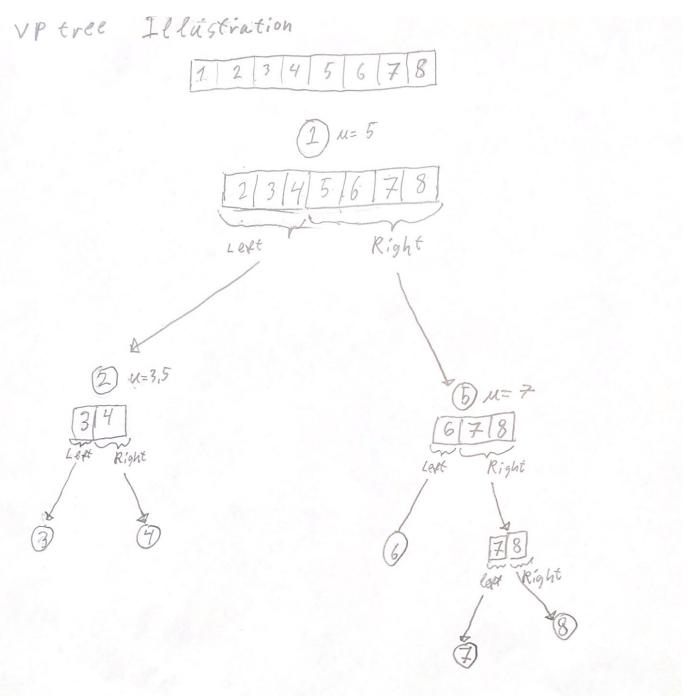

A few things to note: this approach will produce an almost balanced tree. In the article, they mention a depth of $\lfloor \log_2(n) + 1 \rfloor$ which seems reasonable since the left and right subtrees are typically split into nearly equal sizes.
However, if there are duplicates in the input data, the depth may not follow $\lfloor \log_2(n) + 1 \rfloor$. This is because, at some point, larger portions of the data will be sent to either the left or right subtree, meaning the data split won’t always result in two parts with sizes differing by at most one.

Note that if one uses the Hamming distance $d_{H}(x,y)$, duplicates can be detected by checking if the distance between a node and its parent is zero. This provides a way of simplifying the tree if duplicates become a problem. For now, I will ignore this issue.




#### How the seach work
It seam like the idear for using the median of for the tree is to reject rufly have the point when posbiel.
Wich is crazy smart unfortnatly is is alway posibel.

So here we will look into when is it posbiel to reject halfe the point, wich half and when do on need to seache both.


I have devided this section in to two.

In the fist section the main idear will be pressented.

In the second section this idear will be exted.



#### The simpel example

Asume that VP tree is build and that, a user gives a data point intrest the quarry ($q$) and maximum numer of diffrence/distance $R_max$ Here we asume that we working with a propper distnace (The Hamming distance).
I want all the point with distance less than $R_max$. 
so $x|d_H(q,x)\leq R_{Max}$

Let $Node_{x}$ be the node that is in the point $x$

Asume I start in the top of tree, in the root node.
I want to know tree thing's.

1) Should the Point in the node be incluede i the output

- Answer: if the $d_H(q,x)\leq R_{Max}$ when yes otherwise No

2) Should the points in the left list be searched

3) Should the points in the Right list be searched

If the $Node_x$ is a leaf when No, since their is no left and right list.

So let look at the case their $Node_{x}$ is not leaf, and look under wich condtions $Node_{x}$ should be searched.



### Illustration cases 

Below is small ilustration for visual visual aids.

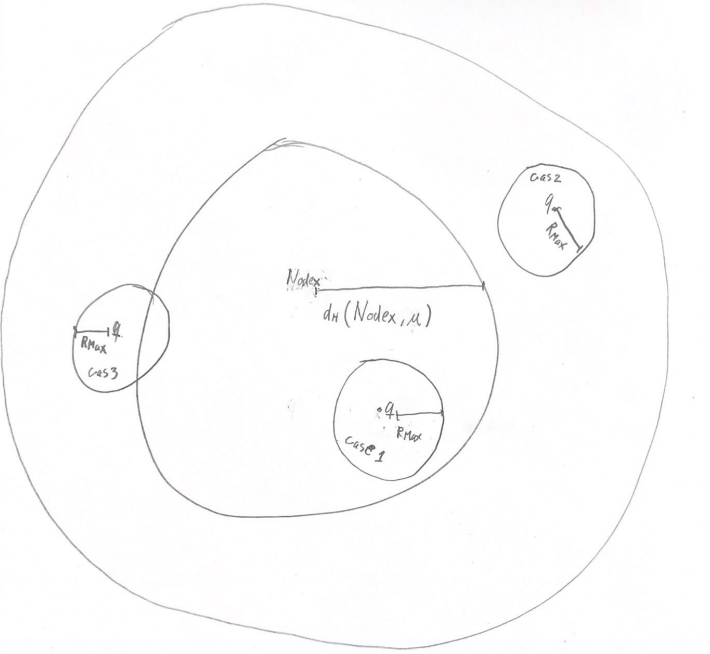

The ilstutration show's the three senaries one can have in the $Node_{x}$.
Note that left is iner and right is outer 

a) Case 1: The left list should be seahces, but right should not.

b) Case 2: The left list should not be seahces, but the right should

c) Case 3: Both left and right list should be seached.

Looking at case 2) when should one seach the inner ball

If the conditon 

$$|d_H(q,Node_x)-d_H(Node_x,\mu)|\leq R_{Max}$$
Is forfilled then the inner ball should be seached.

This can be rewritten as 
$$d_H(Node_x,\mu)-R_{Max}\leq d_H(q,Node_x)\leq d_H(Node_x,\mu)+ R_{Max}$$

one should seach the inner ball


Looking at case 3) 

When to seaches the outer ball

If $d_H(Node_x,\mu) + R_{Max}\geq d_H(q,Node_x)$
Then the outerball should be seaces



#### What happens in the algorithm/implementasion 


What happens in the algorithm/implementation
The algorithm works a little differently.
Remember that the left list contains all values with distances smaller than the median distance to the node point ($Node_x$).

When the tree is built, each node retains the following information:

Node point
Left.min: the smallest distance from the point $Node_x$ in the left list.
Left.max: the largest distance from the point $Node_x$ in the left list.
Right.min: the smallest distance from the point $Node_x$ in the right list (this is the median).
Right.max: the largest distance from the point $Node_x$ in the right list.
This provides more cases for efficient searching.

#### Ilustration
Her is a visual aid for instration of the central cases

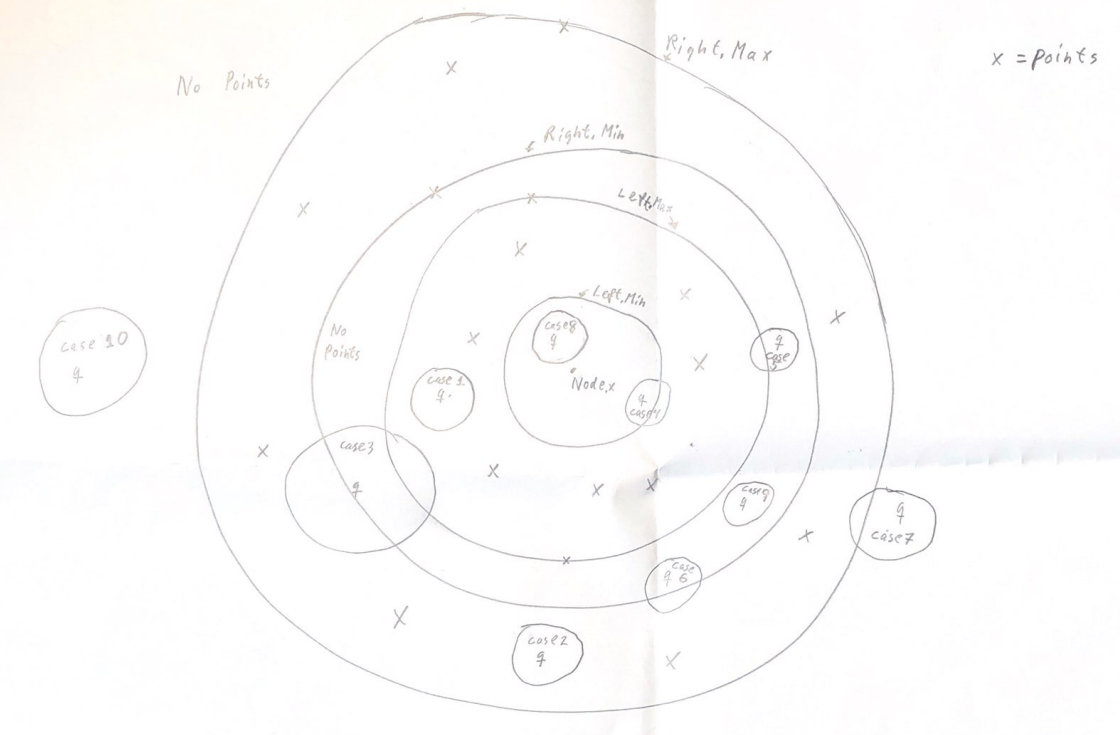

The cases 1, 2, and 3 are the same as before and should be checked.

In cases 4, 5, 6, and 7, the query point 
𝑞
q is outside the ball, but should still be searched since there is overlap with a ball.

Cases 8, 9, and 10 exist in the void, meaning no point exists, and they should not be searched.

It should be noted that if the point $Node_x$ should be included in the return, it is checked separately.

A point cannot be in both the inner list and the outer list.

To determine if a list should be searched:

1) Check if $list.min\leq d_H(q,x)\leq list.max$

- This would indicate that the query point is included in the space between the min and max values.

2) Check if the ball with center at q and radius $R_{max}$ overlaps:
    This is done by checking $list.min - R_{max} \leq  d_H(q,x) \leq list.max +R_{max}$

This would indicate that there is overlap between the balls, and the list should be searched.

Since the query point cannot be included in both the left and right lists, the second step is crucial. By using the min and max values, one can also identify the void cases, as well as cover cases 4 to 7.

#### Posibel improvenment.
A good question is whether the method can be improved.

A fairly easy way to improve the method is by determining when one can be certain that all values in either the left or right list should be returned.

It should be possible to determine if all elements in one of the left or right lists should be included.

If $R_{max} + d_H(q, Node_x) \leq list.max \rightarrow d_H(q, Node_x) \leq R_{max} - list.max$.

If this is implemented, the structure would need to be changed.

As the implementation is now, the $Node_x$ does not contain a list of elements in the right or left list. This means the only way to access the left list is by traversing the tree. Since these elements will pass the condition for being included, they will be included in the returned output anyway.

Minimizing the Bound
In theory, one can adjust the bound as one traverses the tree.

The way to do this is by creating a variable in each node, called $N_{Max\ None}$
 , for each node, and adjusting the maximum distance as one traverses the tree. This would be a small change to the get_in_range function. The post-processing step is still needed, but this could lead to an improvement in minimizing the size of post-processing.

This would be the extent of this project and has not been implemented yet.

## Naive and Benchmark Methods
It should be noted that there are other options for finding cgMLST. Two of these are presented below.

The question of interest is which elements in the database have a small difference from a user-specified input. Below, two methods for this are presented. The common denominator is that both methods need to run through the entire database to find matches.

### Benchmark Method
Given a point of interest (query point q), a database/list of points S, and a maximum difference $R_{Max}$, along with a distance measure that accounts for the user-specified way of handling missing values, the "*Benchmark Method*" works as follows:

Find the distance between the query point q and all elements in the list.
If the distance between the query point and an element in the database is less than the maximum difference, the element is added to the list of results.


### Naive Method
The idea behind the "*Naive Method*" is similar to the "Benchmark Method". However, since the user is only interested in elements with a maximum difference less than $R_{Max}$, and given that calculating the Hamming distance involves comparing sequences element by element, this method allows for early termination:

If the number of mismatches exceeds $R_{Max}$ during the comparison, the process can stop early without continuing the rest of the calculation.


# Code

## Prototype 

In the first section, I built a prototype to evaluate whether the method performs satisfactorily. This prototype is based only on the Hamming distance, and not on our special case of the distance.

Tests have been added, as some of the functions could be useful in the build for SSI.

I would like to hand over the prototype since I won't be available to fix potential issues. The prototype provides a good way to understand the core concept of the VP-tree, which can make it easier to follow what is happening in the final build.

It also allows for speed testing.

I have not done extensive documentation of the prototype since it is a middle step for quickly building and testing the concept.

I have tested the function I built.


The implementation of VP-trees is sourced from a user on GitHub under an open license.

Sources:https://github.com/RickardSjogren/vptree

In [1]:
# Naive implentasion check
def check_adjust_missing_val(
        var_1:list,#varibel one
        var_2:list, #varibel two
        count_None_as_match:bool = True
    ):
    """This function is used for hammin distance where mathces is couted as 0 and miss matches is counted as 1
    It can be bit confusing to look in the code this is since the output is negated. 
    """
    re_ob=None
    if (count_None_as_match==True):
        if (var_1==var_2):
            re_ob= False
        else:
            if (var_1==None or var_2==None):
                re_ob= False
            else:
                re_ob= True
    else:
        if (var_1==None or var_2==None):
            re_ob= True
        elif(var_1==var_2):
            re_ob= False
        else:
            re_ob=True
    return re_ob
            

        



def hamming_distance(vec1:list,
                    vec2:list,
                    count_None_as_match:bool = True
                    ):
    if len(vec1) != len(vec2):
        raise ValueError("Vectors must be of the same length")
    return sum(check_adjust_missing_val(el1,el2,count_None_as_match=count_None_as_match) for el1, el2 in zip(vec1, vec2))


# Test

def test_hamming_distance():
    vec1 = [1,2,3,4]
    vec2 = [1,1,4,3]
    vec3 = [1,None,4,3]
    # Missing values is match
    assert hamming_distance(vec1,vec2) ==3
    assert hamming_distance(vec1,vec3) ==2
    # Missing values is not penelised
    assert hamming_distance(vec1,vec2,count_None_as_match=False) ==3
    assert hamming_distance(vec1,vec3,count_None_as_match=False) ==3


test_hamming_distance()





In [2]:
# Naive implentasion in python

# This function checks if the distance is less than max_dist and return the distance if that is the case.
# otherwise it return None
def check_input_hamming_distance_less_R(
    vec1:list, #vetor for comparionson
    vec2:list, #vetor for comparionson
    max_dist:float, # maxi distance one whish to compare
    return_dist:bool=True,# if the the distance should be a returned
    count_None_as_match:bool=True
    ):
    if(len(vec1)!=len(vec2)):
        print("The two vectors must have equal length")
        return(None)
    
    hamming_distance_var = 0
    for i in range(len(vec1)):
        hamming_distance_var += check_adjust_missing_val(vec1[i],vec2[i],count_None_as_match=count_None_as_match)
        if (hamming_distance_var>max_dist):
            if(return_dist==True):
                return((False,None))
            else:
                return False
    if (return_dist==True):
        return(True,hamming_distance_var)
    else:
        return True
    

# note to self,I need to make sure end user get confuess if it <=  or < 
# if have not restricted C to be a int, the code woulde work but maybe this should be done
# this can be made faster in C++ since it a loop. second option is to to vetorize but i would need a trick to stop the calculations

def test_check_input_hamming_distance_less_R():
    vec1 = [1,2,3,4]
    vec2 = [1,1,4,3]
    vec3 = [1,None,4,3]
    # check with return_dist = False
    #check for none
    assert check_input_hamming_distance_less_R(vec1,vec2=[1],max_dist=3,return_dist=False,count_None_as_match=True) ==None
    #check for over R
    assert check_input_hamming_distance_less_R(vec1,vec2,max_dist=4,return_dist=False,count_None_as_match=True) == True
    #check for under R
    assert check_input_hamming_distance_less_R(vec1,vec3,1,return_dist=False,count_None_as_match=True) == False

    # check with return_dist = True
    assert check_input_hamming_distance_less_R(vec1,[1],3,return_dist=True,count_None_as_match=True) ==None
    #check for over R
    assert (check_input_hamming_distance_less_R(vec1,vec2,4,return_dist=True,count_None_as_match=True)[0]) == True
    #check for under R
    assert check_input_hamming_distance_less_R(vec1,vec3,1,return_dist=True,count_None_as_match=True)[0] == False
    # check if the distance is give the right values
    assert check_input_hamming_distance_less_R(vec1,vec2,1,return_dist=True)[1]==None # the distance is greater
    # check if the distance is corret if the max_dist is above
    assert check_input_hamming_distance_less_R(vec1,vec3,5,return_dist=True)[1]==2

    # Check with Count None as match
    
    #check for none
    assert check_input_hamming_distance_less_R(vec1,[1],3,return_dist=False,count_None_as_match=False) ==None
    #check for over R
    assert check_input_hamming_distance_less_R(vec1,vec2,4,return_dist=False,count_None_as_match=False) == True
    #check for under R
    assert check_input_hamming_distance_less_R(vec1,vec3,1,return_dist=False,count_None_as_match=False) == False

    # check with return_dist = True
    assert check_input_hamming_distance_less_R(vec1,[1],3,return_dist=True,count_None_as_match=False) ==None
    #check for over R 
    assert (check_input_hamming_distance_less_R(vec1,vec2,4,return_dist=True,count_None_as_match=False)[0]) == True
    #check for under R
    assert check_input_hamming_distance_less_R(vec1,vec3,1,return_dist=True,count_None_as_match=False)[0] == False
    # check if the distance is give the right values
    assert check_input_hamming_distance_less_R(vec1,vec2,1,return_dist=True,count_None_as_match=False)[1]==None # the distance is greater
    
    # check if the distance is corret if the max_dist is above
    assert check_input_hamming_distance_less_R(vec1,vec3,5,return_dist=True,count_None_as_match=False)[1]==3


test_check_input_hamming_distance_less_R()



The two vectors must have equal length
The two vectors must have equal length
The two vectors must have equal length
The two vectors must have equal length


In [3]:
# Function for generation testcases.
import numpy as np
from copy import copy
from scipy.stats import binom
dtype = np.uint8

# This is taken from kristoffers github. https://github.com/kriskiil/cgmlstsearch/blob/master/cgmlstsearch.py
def create_seqs(nseqs:int,# Number of sequantion
                l:int, # Length
                diversity, # how different they are
                seed:int=100 # sead for reoroducabillaty
                ):
    """Create random seqs"""
    allele_maxima = np.ones(l)
    originalseq = np.ones(l)
    #originalseq = np.random.randint(low=1,high=diversity,size=l)
    seqs = np.ndarray((nseqs,l),dtype=dtype)
    seqs[0] = originalseq
    #distances = np.random.poisson(diversity,size=nseqs-1)
    distances = np.random.binomial(l,diversity/l,size=nseqs-1)
    n = 0
    for i in distances:
        n += 1
        sites = np.random.choice(l,size=i, replace=False)
        originalseq = seqs[np.random.choice(n)]
        newseq = copy(originalseq)
        allele_maxima[sites] += 1
        newseq[sites] = allele_maxima[sites]
        #newseq[sites] = np.random.randint(low=1,high=diversity,size=i)
        seqs[n] = newseq
    return seqs


# not test since its stocatik


# maybe change generating function diversity is the number (1,divsersity) ins drawn from. and ad second parameter to how may time this should happen.


#Returns a list  element with Haming dsitance less than C, in the database. The element in the list is tupels with index in the database and a the vector.
#  


from collections import deque


def get_naiv_implementasion(points:list, #list of list containg points 
                        query:list,
                        max_dist: int,
                        return_dist:bool = True,
                        count_None_as_match:bool = True):
    Return_list = deque() # make list for values
    if(return_dist==False):
        for i in range(0,len(points)):
            if check_input_hamming_distance_less_R(points[i],query,max_dist,return_dist=False,count_None_as_match=count_None_as_match)==True:
                Return_list.append((points[i],i))
    else:
        for i in range(0,len(points)):
            output_check_input= check_input_hamming_distance_less_R(points[i],query,max_dist,return_dist=True,count_None_as_match=count_None_as_match)
            if (output_check_input[0]==True):
                Return_list.append((output_check_input[1],points[i],i))
    return Return_list


# simple test of Naiv_implementasion
def test_get_naiv_implementasion():
    n=200
    size=2000
    diversity=35
    generated_test_data=create_seqs(n,size,diversity)
    test_index=np.random.randint(0,(n-1))

    # test for non return values for distance 
    test_output=get_naiv_implementasion(generated_test_data,generated_test_data[test_index],1,return_dist=False)
    assert (test_output[0][1]==test_index)
    assert all(test_output[0][0]==(generated_test_data[test_index]))
    # test with return values
    test_output=get_naiv_implementasion(generated_test_data,generated_test_data[test_index],1,return_dist=True)
    assert (test_output[0][2]==test_index)
    assert all(test_output[0][1]==(generated_test_data[test_index]))

test_get_naiv_implementasion()



In [4]:
# This code is copied from.
# https://github.com/RickardSjogren/vptree 
#  I made minor change to the function dist function structure to facilta the index of the datbase is given as a output.




""" This module contains an implementation of a Vantage Point-tree (VP-tree)."""
import bisect
import collections
import math
import statistics as stats


class VPTree:

    """ VP-Tree data structure for efficient nearest neighbor search.

    The VP-tree is a data structure for efficient nearest neighbor
    searching and finds the nearest neighbor in O(log n)
    complexity given a tree constructed of n data points. Construction
    complexity is O(n log n).

    Parameters
    ----------
    points : Iterable
        Construction points.
    dist_fn : Callable
        Function taking to point instances as arguments and returning
        the distance between them.
    leaf_size : int
        Minimum number of points in leaves (IGNORED).
    """

    def __init__(self, points, dist_fn,Sup_tree=False):
        self.left = None
        self.right = None
        self.left_min = math.inf
        self.left_max = 0
        self.right_min = math.inf
        self.right_max = 0
        self.dist_fn = dist_fn
        self.dist_fn_internal_points = dist_fn # change made
        self.dist_fn_external_and_internal_points = dist_fn # cahnge made
        self.Sup_tree=Sup_tree

        if not len(points):
            raise ValueError('Points can not be empty.')
        # set index on tree
        if(Sup_tree==False): # change made
            # If it the root of the tree redefine point so index follows the points
            index_list=list(range(0,len(points)))
            points=list(zip(points,index_list))
            # redefine the distance so it do not parse the index into the distance function
            self.dist_fn_internal_points = lambda q,p: dist_fn(q[0],p[0])
            self.dist_fn_external_and_internal_points = lambda q_external,p_internal: dist_fn(q_external,p_internal[0])

            #if this is done when it not the root the points will get sub index in a way that is not good

        # Vantage point is point furthest from parent vp.
        self.vp = points[0]
        points = points[1:]

        if len(points) == 0:
            return
        
        
        # Choose division boundary at median of distances.
        distances = [self.dist_fn_internal_points(self.vp, p) for p in points]
        median = stats.median(distances)

        left_points = []
        right_points = []
        for point, distance in zip(points, distances):
            if distance >= median:
                self.right_min = min(distance, self.right_min)
                if distance > self.right_max:
                    self.right_max = distance
                    right_points.insert(0, point) # put furthest first
                else:
                    right_points.append(point)
            else:
                self.left_min = min(distance, self.left_min)
                if distance > self.left_max:
                    self.left_max = distance
                    left_points.insert(0, point) # put furthest first
                else:
                    left_points.append(point)
        if len(left_points) > 0:
            self.left = VPTree(points=left_points, dist_fn=self.dist_fn_internal_points,Sup_tree=True)

        if len(right_points) > 0:
            self.right = VPTree(points=right_points, dist_fn=self.dist_fn_internal_points,Sup_tree=True)

    def _is_leaf(self):
        return (self.left is None) and (self.right is None)

    def get_nearest_neighbor(self, query):
        """ Get single nearest neighbor.
        
        Parameters
        ----------
        query : Any
            Query point.

        Returns
        -------
        Any
            Single nearest neighbor.
        """
        return self.get_n_nearest_neighbors(query, n_neighbors=1)[0]

    def get_n_nearest_neighbors(self, query,# point of interest  
                                 n_neighbors#Number of neighbors
                                 ):
        """ Get `n_neighbors` nearest neigbors to `query`
        
        Parameters
        ----------
        query : Any
            Query point.
        n_neighbors : int
            Number of neighbors to fetch.

        Returns
        -------
        list
            List of `n_neighbors` nearest neighbors.
        """
        if not isinstance(n_neighbors, int) or n_neighbors < 1:
            raise ValueError('n_neighbors must be strictly positive integer')
        neighbors = _AutoSortingList(max_size=n_neighbors)
        queue = collections.deque([self])
        furthest_d = math.inf
        need_neighbors = True

        while queue:
            node = queue.popleft() # Take smallest value out of queue and set is a node.
            if node is None: # If the node is empty alle points is checked in the queue, and the process is empty
                continue 
            d = self.dist_fn_external_and_internal_points(query, node.vp) # Find distance from query to point.

            if d < furthest_d or need_neighbors: # If the distance is smaller than what is found or the their is less than n neighbors 
                neighbors.append((d, node.vp)) # node to neighbors.
                furthest_d = neighbors[-1][0] # update furthest distance 
                if need_neighbors:
                    need_neighbors = len(neighbors) < n_neighbors # update if theirs is N neighbors

            if node._is_leaf(): # if the node is leaf one can not go left or right terminate.
                continue

            if need_neighbors: 
                if d < node.left_max + furthest_d:
                    queue.append(node.left)
                if d >= node.right_min - furthest_d:
                    queue.append(node.right)
            else:
                if node.left_min - furthest_d < d < node.left_max + furthest_d:
                    queue.append(node.left)
                if node.right_min - furthest_d <= d <= node.right_max + furthest_d:
                    queue.append(node.right)

        return list(neighbors)

    def get_all_in_range(self, query, max_distance):
        """ Find all neighbours within `max_distance`.

        Parameters
        ----------
        query : Any
            Query point.
        max_distance : float
            Threshold distance for query.

        Returns
        -------
        neighbors : list
            List of points within `max_distance`.

        Notes
        -----
        Returned neighbors are not sorted according to distance.
        """
        neighbors = list()
        nodes_to_visit = [(self, 0)]

        while len(nodes_to_visit) > 0:
            node, d0 = nodes_to_visit.pop(0)
            # if the list of Nodes is empty and ore d0, larger than max dist skip
            if node is None or d0 > max_distance:
                continue
            #find distance to point
            d = self.dist_fn_external_and_internal_points(query, node.vp)
            # if dist to point is lees than max_dist append to list, add naibor
            if d < max_distance:
                neighbors.append((d, node.vp))

            if node._is_leaf():
                continue 
            # If the node is a leaf their is no reson for looking at right of leaf list since they do not exist

            if node.left_min <= d <= node.left_max:
                nodes_to_visit.insert(0, (node.left, 0))
                # If the distance to quary point is between min and max, ad the points from the left to point that need to visited

            elif node.left_min - max_distance <= d <= node.left_max + max_distance:
                """
                d <= node.left_max + max_distance: comes from d-left_max>max_distance
                This is the case there the point quary is outside the balle withe cetner i node.vp and node.left_max as radius,
                but the ball with center in the quray point and radisus max dist has overlab with the inner ball

                node.left_min - max_distance < d comes from the case q is inside the innerball, center in node.vp radius node.left_min
                if d+max_distance > node.left_min when their will be a overlab between the ball with center q and radisus max dist
                and the are point cane be between node.left_min and node.left_max.

                """
                nodes_to_visit.append((node.left,
                                       node.left_min - d if d < node.left_min
                                       else d - node.left_max))
                """the distance pas to d0 is the same as the condtion above, This seam like a double check,
                  it a littel unclear to me why both is need. since the condtion is checked befor the point is added to naibors.
                  """
                
            if node.right_min <= d <= node.right_max:
                nodes_to_visit.insert(0, (node.right, 0))
            elif node.right_min - max_distance <= d <= node.right_max + max_distance:
                nodes_to_visit.append((node.right,
                                       node.right_min - d if d < node.right_min
                                       else d - node.right_max))

        return neighbors

# this can proberly be improved
class _AutoSortingList(list):

    """ Simple auto-sorting list.

    Inefficient for large sizes since the queue is sorted at
    each push.

    Parameters
    ---------
    size : int, optional
        Max queue size.
    """

    def __init__(self, max_size=None, *args):
        super(_AutoSortingList, self).__init__(*args)
        self.max_size = max_size

    def append(self, item):
        """ insert `item` in sorted order

        Parameters
        ----------
        item : Any
            Input item.
        """
        self.insert(bisect.bisect_left(self, item), item)
        if self.max_size is not None and len(self) > self.max_size:
            self.pop()

In [5]:
# Test of correctness of 
import time # import time


def sort_tuples_by_inner_and_outer_value(input_list):
    """Sort the list of tuples based on the second integer in the inner tuple,
     and in case of ties, sort based on the first integer in the outer tuple.
     """
    return sorted(input_list, key=lambda x: (x[1][1], x[0]))


# this is a test function that test the VP implentasion up against the naive methods.

# I have drawn point in the database since it seam like the test function alway starts i [1,1,...1]
# wich mean if generate a point for test it will alway be the same
def test_VP_tree_vs_naive_method(n=200,
                                 size=20000,
                                 diversity=25,
                                 test_max_dist=50
                                 ):
    test_index=np.random.randint(0,(n-1))
    generated_test_data=create_seqs(n,size,diversity)
    #Naive implemtasion
    start_time_naive_implementasion = time.time()
    # Running implication
    test_output_Naiv_implementasion_Full_dist=get_naiv_implementasion(generated_test_data,generated_test_data[test_index],test_max_dist)
    stop_time_naive_implementasion = time.time() 

    diff_time_naive_implementasion=stop_time_naive_implementasion-start_time_naive_implementasion

    # Construct tree
    test_tree=VPTree(generated_test_data,hamming_distance)
    
    start_time_VP_tree = time.time() 
    # Run function
    NNS_test_tree=test_tree.get_all_in_range(generated_test_data[test_index],test_max_dist)

    stop_time_VP_tree = time.time() 

    diff_time_VP_tree=stop_time_VP_tree-start_time_VP_tree

    #Sort based on index
    NNS_test_tree_sorted=sort_tuples_by_inner_and_outer_value(NNS_test_tree)
    #Do length of the two mathods match
    
    assert(len(test_output_Naiv_implementasion_Full_dist)==(len(NNS_test_tree_sorted)))
    # Mak list for check
    matching_distance=[]
    macthing_point=[]
    Macthing_index=[]
    for i in range(len(test_output_Naiv_implementasion_Full_dist)): 
        #matcing ditance 
        matching_distance.append(NNS_test_tree_sorted[i][0]==test_output_Naiv_implementasion_Full_dist[i][0])
        # matching point output
        macthing_point.append(all(NNS_test_tree_sorted[i][1][0]==(test_output_Naiv_implementasion_Full_dist[i][1])))
        # matching index
        Macthing_index.append(NNS_test_tree_sorted[i][1][1]==test_output_Naiv_implementasion_Full_dist[i][2])
    assert(all(matching_distance))
    assert(all(macthing_point))
    assert(all(Macthing_index))

    output_list=["Since the function give a output it means theirs a perferct match between the naive implentasion and VP-tree's",
                 ("Number of matches in test",len(test_output_Naiv_implementasion_Full_dist)),
                 ("Time for naive implementasion",diff_time_naive_implementasion),
                 ("Time for VP-tree",diff_time_VP_tree),
                 ("Difference in time between implementasion (posetive values mean VP fastes)",diff_time_naive_implementasion-diff_time_VP_tree)

                 ]
    return(output_list)
tets_ob=(test_VP_tree_vs_naive_method())

for ob in(tets_ob):
    print(ob)


Since the function give a output it means theirs a perferct match between the naive implentasion and VP-tree's
('Number of matches in test', 8)
('Time for naive implementasion', 0.5255162715911865)
('Time for VP-tree', 0.4601573944091797)
('Difference in time between implementasion (posetive values mean VP fastes)', 0.06535887718200684)


In [6]:
# this will test if the above VP tree seach give 
def test_small_test(dist):
    Points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,2],
        [1,1,1,1,1,1,2,2],
        [1,1,1,1,1,2,2,2],
        [1,1,1,1,2,2,2,2],
        [1,1,1,2,2,2,2,2]
    ]
    test_tree=VPTree(Points,hamming_distance)
    test_point=[1,1,1,1,1,1,1,3]
    return test_tree.get_all_in_range(test_point,max_distance=dist)
print("small test of tree")
print("the tree less than 2")
print(test_small_test(2))
print("the tree less than 3")
print(test_small_test(3))
print("conclusion the tree retun values les than the distiacne not less equal")

small test of tree
the tree less than 2
[(1, ([1, 1, 1, 1, 1, 1, 1, 1], 0)), (1, ([1, 1, 1, 1, 1, 1, 1, 2], 1))]
the tree less than 3
[(1, ([1, 1, 1, 1, 1, 1, 1, 1], 0)), (2, ([1, 1, 1, 1, 1, 1, 2, 2], 2)), (1, ([1, 1, 1, 1, 1, 1, 1, 2], 1))]
conclusion the tree retun values les than the distiacne not less equal


### Conclusion on prototype

The method give the correct output and seam to preform faster than the naive method.

## Code version two.
The approach described above works and was a quick way to check if the concept would function. In this section, I build what can be used in the actual application.

The main idea is to create a class containing a VP tree based on Hamming distance.

The class should contain the desired search function to retrieve all points within a given range of a query, using a chosen method for handling None values.

I have designed it so that additional information can be passed into the class, besides the points themselves. In my test, I used an index to test the application, but in a real environment, this could be additional information such as date, time, or other metadata. You could also use a list or other formats for storing more than one piece of information.

The goal is to create a class that functions properly. Note that in the previous section, I made small adjustments to the VP tree code to make it work with indexed points. In the code below, I do it slightly differently. I also add a function to choose the root points.

To be clear, these are small tweaks to the VP-tree code.

I’ve written headers and documentation for the functions so they are easily readable when calling the Python functions. I’ve also written tests for the code, primarily using black-box testing, though I remember attempting to cover the code fully, so for the most part, it should also include white-box testing.

I have written docstrings for most of the functions and included extensive comments in the code. For smaller functions, I have written a brief description but not a full docstring. Many of these functions could, and probably should, be replaced by some Python libraries for speed improvements. This project is built in Python, but the real-world implementation could be in another language, so it seems like a good idea to build them from the ground up. This ensures that a clear method for implementing all the functions is available, and they can be replaced if needed.

I have not written exampels, since the test is available.


#### Base Function
In this code chunk, the smaller base function is built and tested.
The docstrings for these are kept sparse.

In [7]:
# Here the helper function is defined

import collections

from collections import deque


def get_number_missing_values(
        input:list
        ): # list of list
    """ This function returns the number of missing values in a list. 
    """
    L_list=len(input)
    if (L_list==0):
        raise ValueError("List must have length greater than one")
    count = 0
    for i in range(L_list):
        if (input[i]==None):
            count = count + 1
    return count


def test_get_number_missing_values():
    vec1 = [1,2,3,4]
    vec2 = [None,1,4,None]
    vec3 = [1,2,4,None]
    vec4 = [2,None,5,3]
    assert get_number_missing_values(vec1)==0
    assert get_number_missing_values(vec2)==2
    assert get_number_missing_values(vec3)==1
    assert get_number_missing_values(vec4)==1

test_get_number_missing_values()
del test_get_number_missing_values

def get_number_missing_values_list(
        input: list # list of list
        ):
    """This function count the number of missing values (None) in each entrances of a list.
    If the input was matrix this would corespond to the number missing values in each row"""
    
    if (len(input)==0):
        raise ValueError("The input list is empty")
    #run through outer list
    List_Return = collections.deque()
    for i in range(len(input)):
        List_Return.append(get_number_missing_values(input[i]))
    return List_Return
    




def test_get_number_missing_values_list():
    test_list1=[[1,2,3],[2,3,None]]
    assert get_number_missing_values_list(test_list1)==collections.deque([0,1])
    test_list2=[[1,None],[None,None]]
    assert get_number_missing_values_list(test_list2) ==collections.deque([1,2])
    test_list3 =[[1,0,2],[1,2]]
    assert get_number_missing_values_list(test_list3) ==collections.deque([0,0])

test_get_number_missing_values_list()       
del test_get_number_missing_values_list


# Naive implentasion check
def check_adjust_missing_val(
    var_1,#varibel one
    var_2, #varibel two
    count_None_as_match:bool=True
    ):
    """
    This function checek if two varibels is the same. It let the user specifie if missing values should count as a match ore not
    """
    # for the true and false is because True is one and False is zero so compared to a indicator funtion this is negated.
    # meaning the reverse.
    re_ob=None
    if (count_None_as_match==True):
        if (var_1==var_2):
            re_ob= False
        else:
            if (var_1==None or var_2==None):
                re_ob= False
            else:
                re_ob= True
    else:
        if (var_1==None or var_2==None):
            re_ob= True
        elif(var_1==var_2):
            re_ob= False
        else:
            re_ob=True
    return re_ob




def hamming_distance_altered(
        vec1:list,
        vec2:list,
        count_None_as_match:chr="T"):
    """
    This function return the hamming distance, their is three option for handling missing values.
    If Count_None_as_match =="T" None values will be counted as match meaning no penalty is added (+0)
    If Count_None_as_match =="F" None values will be counted as error meaning 1+ add even if both entraces is None
    If Count_None_as_match =="Normal" None will be treated as a charter in the list. If both entrance in the list is None when no penalty is added, otherwise a penalty is added.
    Note that the options Count_None_as_match =="T" and Count_None_as_match =="F", make out note a measure
    """
    return_ob= None
    if len(vec1) != len(vec2):
        raise ValueError("Vectors must be of the same length")
    if (count_None_as_match=="T"):
        return_ob= sum(check_adjust_missing_val(el1,el2,count_None_as_match=True) for el1, el2 in zip(vec1, vec2))
    if (count_None_as_match=="F"):
        return_ob= sum(check_adjust_missing_val(el1,el2,count_None_as_match=False) for el1, el2 in zip(vec1, vec2))
    if(count_None_as_match=="Normal"):
        count = 0
        for i in range(len(vec1)):
            count = count + (vec1[i]!=vec2[i])
        return_ob= (count)
    return return_ob


def test_hamming_distance_altered():
    vec1 = [1,2,3,4]
    vec2 = [1,1,4,3]
    vec3 = [1,None,4,3]
    vec4 = [2,None,5,3]
    # Missing values is match
    assert hamming_distance_altered(vec1,vec2,"T") ==3
    assert hamming_distance_altered(vec1,vec3,"T") ==2
    # Missing values is not penelised
    assert hamming_distance_altered(vec1,vec2,count_None_as_match="F") ==3
    assert hamming_distance_altered(vec1,vec3,count_None_as_match="F") ==3
    assert hamming_distance_altered(vec3,vec3,count_None_as_match="F") ==1 # distance to selv over 0 not measure 

    
    # Missing values is treated like charter in string.
    assert hamming_distance_altered(vec1,vec2,"Normal") == 3
    assert hamming_distance_altered(vec1,vec3,"Normal") == 3
    assert hamming_distance_altered(vec3,vec4,"Normal") == 2
    assert hamming_distance_altered(vec3,vec3,"Normal") == 0


test_hamming_distance_altered()
del test_hamming_distance_altered



#### Hamming Distance with Early Stopping
In this code chunk, the Hamming distance with early stopping is built and tested.

A variable indicates the chosen method for handling missing values.

This function is an internal function for the cgMLST_VP_tree function, and therefore the input format may seem a little strange.

In [8]:
import pytest
def check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(
    vec1:list, #vetor for comparionson
    vec2:list, #vetor for comparionson
    max_dist:int, # maxi distance one whish to compare
    return_dist:bool = True,# if the the distance should be a returned
    count_None_as_match:chr = "T"
    ):
    """
    Check if the Hamming distance between two input vectors is less than or equal to `max_dist`. 
    The function terminates early and returns as soon as the distance exceeds `max_dist`.
    The function is build to be used in the class cgMLST_VP_tree. but if keept outside for esay testing.
    
    Special handling is provided for `None` values in the vectors, with the behavior determined 
    by the `Count_None_as_match` parameter.

    Parameters
    ----------
    vec1 : list
        A list containing values from cgMLST for comparison.
    
    vec2 : list
        A second list containing values from cgMLST for comparison.
    
    max_dist : int
        The maximum allowable Hamming distance between the two vectors. If the distance exceeds this value,
        the function returns `False`.
    
    return_dist : bool, optional (default=True)
        If `True`, the function returns the Hamming distance along with the result.
        If `False`, only the boolean result (True/False) is returned.
    
    Count_None_as_match : str, optional (default='T')
        Determines how `None` values in the vectors are treated during the comparison:
        - 'T': Treat `None` as a match (i.e., `None` values are ignored).
        - 'F': Treat `None` as a mismatch.
        - 'Normal': Count `None` as a regular character and apply the standard Hamming distance.
    
    Returns
    -------
    bool or tuple
        If `return_dist` is `False`, the function returns:
            - `True` if the distance between `vec1` and `vec2` is less than or equal to `max_dist`.
            - `False` if the distance is greater than `max_dist`.
        
        If `return_dist` is `True`, the function returns a tuple:
            - `(True, distance)` if the Hamming distance is within the threshold.
            - `(False, None)` if the distance exceeds `max_dist`.
    
    Raises
    ------
    ValueError
        If the lengths of `vec1` and `vec2` are not equal, or if `Count_None_as_match` contains
        an invalid value.
    """
    return_ob=None
    if(len(vec1)!=len(vec2)):
        raise ValueError("The two list must have equal length")
    if(count_None_as_match=="T"):
        return_ob= check_input_hamming_distance_less_R(vec1,vec2,max_dist,return_dist,count_None_as_match=True)
    elif(count_None_as_match=="F"):
        return_ob= check_input_hamming_distance_less_R(vec1,vec2,max_dist,return_dist,count_None_as_match=False)
    elif(count_None_as_match=="Normal"):
        count=0
        for i in range(len(vec1)):
            if(vec1[i]!=vec2[i]):
                count=count+1
            if(count>max_dist):
                break
        
        if(count<=max_dist):
            if(return_dist==True):
                return_ob= (True,count)
            else:
                return_ob= (True)
        else: 
            #count>max_dist
            if(return_dist==True):
                return_ob= (False,None)
            else:
                return_ob= False
    else:
        ValueError("Count_None_as_match do not match any allow input")
    return return_ob


def test_check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree():
    vec1 = [1,2,3,4]
    vec2 = [1,1,4,3]
    vec3 = [1,None,4,3]
    vec4 = [None,None,3,4]
    # check with return_dist = False
    #check for none
    #Check_If_Input_Has_Hamming_Distance_Less_C_internal_cgMLST_VP_tree(vec1,[1],3,return_dist=False,Count_None_as_match="T")==None
    #check for over R 
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec2,4,return_dist=False,count_None_as_match="T") == True
    #check for under R
    
    
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec3,1,return_dist=False,count_None_as_match="T") == False

    # check with return_dist = True
    #with pytest.raises(ValueError, match="The two list must have equal length"):Check_If_Input_Has_Hamming_Distance_Less_C_internal_cgMLST_VP_tree(vec1,[1],3,return_dist=True,Count_None_as_match=True)
    #check for over R
    assert (check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec2,4,return_dist=True,count_None_as_match="T")[0]) == True
    #check for under R
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec3,1,return_dist=True,count_None_as_match="T")[0] == False
    # check if the distance is give the right values
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec2,1,return_dist=True,count_None_as_match="T")[1]==None # the distance is greater
    # check if the distance is corret if the max_dist is above
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec3,5,return_dist=True,count_None_as_match="T")[1]==2

    # Check with Count None as match
    
    #check for none
    #with pytest.raises(ValueError, match="The two list must have equal length"):Check_If_Input_Has_Hamming_Distance_Less_C_internal_cgMLST_VP_tree(vec1,[1],3,return_dist=False,Count_None_as_match=False)
    #check for over C 
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec2,4,return_dist=False,count_None_as_match="F") == True
    #check for under C
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec3,1,return_dist=False,count_None_as_match="F") == False

    # check with return_dist = True
    #with pytest.raises(ValueError, match="The two list must have equal length"): Check_If_Input_Has_Hamming_Distance_Less_C_internal_cgMLST_VP_tree(vec1,[1],3,return_dist=True,Count_None_as_match=False)
    #check for over C 
    assert (check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec2,4,return_dist=True,count_None_as_match="F")[0]) == True
    #check for under C
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec3,1,return_dist=True,count_None_as_match="F")[0] == False
    # check if the distance is give the right values
    #assert Check_If_Input_Has_Hamming_Distance_Less_C_internal_cgMLST_VP_tree(vec1,vec2,1,return_dist=True,Count_None_as_match=False)[1]==None # the distance is greater
    
    # check if the distance is corret if the max_dist is above
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec1,vec3,5,return_dist=True,count_None_as_match="F")[1]==3
    
    # check with normal hamming distance

    #check  True 
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec3,vec4,3,return_dist=True,count_None_as_match="Normal")[0]==True
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec3,vec4,3,return_dist=True,count_None_as_match="Normal")[1]==3

    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec3,vec4,3,return_dist=False,count_None_as_match="Normal")==True
    
    # Check False
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec3,vec4,1,return_dist=True,count_None_as_match="Normal")[0]==False
    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec3,vec4,1,return_dist=True,count_None_as_match="Normal")[1]==None

    assert check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(vec3,vec4,1,return_dist=False,count_None_as_match="Normal")==False
    
    return

test_check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree()



#### Naive Implementation
In this code chunk, the naive implementation is built and tested.

This function is needed for post-processing and for comparison in speed.

In [9]:
def get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(
        points:list, #list of list containg points 
        query:list,
        max_dist:int,
        replace_dist:bool=True,
        count_None_as_match:chr="T",
        is_dist_provided:bool= True
        ):
    """Preform naive method don do in reach search for list of points and a query, point
    Parameters
    ----------
    Point: list of list.
        The list can either be a list of list cotaing only the point of intrest ore if 
        
        query : list 
            List with cgMLST as input. format [] only fist input will be used.
    Max_dist : Max_difference
        The maximum difference: need be larger than number missing value in query if Count_None_as_match is false
    count_None_as_match : chr
        Specifies how `None` values are treated in the comparison. 
        Accepts the following values:
            - 'True' : Treat `None` as a match for all comparison.
            - 'False' : Treat `None` as a non-match for all comparison.
    replace_dist = bool
        If True this function will replace the entrance in the point as i get added to the list.
        If False the point will be append if the chosen distanse is smaller 
    """
    return_list = deque() # make list for values
    if(is_dist_provided==True):
        """
        This is for when the input data is in the format
        points=[
        (distance,(list,obtional)),
        (distance,(list,obtional)),
        (distance,(list,obtional)),...
        (distance,(list,obtional))
        ]
        """
        if (replace_dist==True):
            for i in range(len(points)):
                check_op=check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(points[i][1][0],query,max_dist=max_dist,return_dist=True,count_None_as_match=count_None_as_match)
                if(check_op[0]==True):
                    mid_point=(check_op[1],points[i][1])
                    return_list.append(mid_point)
        else:
            for i in range(len(points)):
                check_op=check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(points[i][1][0],query,max_dist=max_dist,return_dist=True,count_None_as_match=count_None_as_match)
                if(check_op[0]==True):
                    return_list.append(points[i])
        #
    else:
        """This is for when the input data is in the format
        [(list,obtional),(list,obtional),...,(list,obtional)]
        
        """
        if (replace_dist==True):
            for i in range(len(points)):
                check_op=check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(points[i][0],query,max_dist=max_dist,return_dist=True,count_None_as_match=count_None_as_match)
                if(check_op[0]==True):
                    mid_point=(check_op[1],points[i])
                    return_list.append(mid_point)
        else:
            for i in range(len(points)):
                check_op=check_inputs_hamming_distance_less_R_internal_cgMLST_VP_tree(points[i][0],query,max_dist=max_dist,return_dist=True,count_None_as_match=count_None_as_match)
                if(check_op[0]==True):
                    return_list.append(points[i])
    return return_list




# test of function 
def test_get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree():
    points=[
        (100,([1,1,1,8,8,1],None)),
        (20,([1,1,1,2,3,2],None)),
        (25,([None,None,1,1,1,2],None))
        ]
    q=[None,3,4,8,8,None]
    # Count_None_as_match=True
    # test with replaced distance
    test_1=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points,query=q,max_dist=3,count_None_as_match="T",replace_dist=True,is_dist_provided=True))
    assert test_1[0]==(2,([1,1,1,8,8,1],None))
    assert test_1[1]==(3,([None,None,1,1,1,2],None))
    # dont replaced dstiance
    test_2=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points,query=q,max_dist=3,count_None_as_match="T",replace_dist=False,is_dist_provided=True))
    assert test_2[0]==(100,([1,1,1,8,8,1],None))
    assert test_2[1]==(25,([None,None,1,1,1,2],None))

    # Count_None_as_match=False
    # test with replaced distance
    test_3=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points,query=q,max_dist=4,count_None_as_match="F",replace_dist=True,is_dist_provided=True))
    assert test_3[0]==(4, ([1, 1, 1, 8, 8, 1], None))
    #dont replaced dstiance
    test_4=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points,query=q,max_dist=4,count_None_as_match="F",replace_dist=False,is_dist_provided=True))
    assert test_4[0]==(100, ([1, 1, 1, 8, 8, 1], None))

    
    # Test Normal input.
    test_5=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points,query=q,max_dist=4,count_None_as_match="Normal",replace_dist=False,is_dist_provided=True))
    assert test_5[0]==(100,([1,1,1,8,8,1],None))

    test_6=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points,query=q,max_dist=4,count_None_as_match="Normal",replace_dist=True,is_dist_provided=True))
    assert test_6[0]==(4,([1,1,1,8,8,1],None))
    #
    """
    test for format 
    [(list,obtional),(list,obtional),...,(list,obtional)]
    [([None, 1, 1, 1, 1, 1, 1, 1], 2), ([None, None, 1, 1, 1, 1, 1, 2], 3), ([None, None, None, 1, 1, 1, 2, 2], 4)]
    """
    points_2=[
        ([1,1,1,8,8,1],None),
        ([1,1,1,2,3,2],None),
        ([None,None,1,1,1,2],None)
        ]
    q_2=[None,3,4,8,8,None]
    # Count_None_as_match=True
    # test with replaced distance
    test_7=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_2,query=q_2,max_dist=3,count_None_as_match="T",replace_dist=True,is_dist_provided=False))
    
    assert test_7[0]==(2,([1,1,1,8,8,1],None))
    assert test_7[1]==(3,([None,None,1,1,1,2],None))
    # dont replaced dstiance
    
    test_8=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_2,query=q_2,max_dist=3,count_None_as_match="T",replace_dist=False,is_dist_provided=False))
    
    assert test_8[0]==([1,1,1,8,8,1],None)
    assert test_8[1]==([None,None,1,1,1,2],None)

    # Count_None_as_match=False
    # test with replaced distance
    test_9=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_2,query=q_2,max_dist=4,count_None_as_match="F",replace_dist=True,is_dist_provided=False))
    assert test_9[0]==(4, ([1, 1, 1, 8, 8, 1], None))
    #dont replaced dstiance
    test_9=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_2,query=q_2,max_dist=4,count_None_as_match="F",replace_dist=False,is_dist_provided=False))
    assert test_9[0]==([1, 1, 1, 8, 8, 1], None)

    
    # Test Normal input.
    test_9=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_2,query=q_2,max_dist=4,count_None_as_match="Normal",replace_dist=False,is_dist_provided=False))
    assert test_9[0]==([1,1,1,8,8,1],None)

    test_10=list(get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_2,query=q_2,max_dist=4,count_None_as_match="Normal",replace_dist=True,is_dist_provided=False))
    assert test_10[0]==(4,([1,1,1,8,8,1],None))
    
    return 
test_get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree()




#### Select Node
In this section, the selected node function is built and tested.

In [10]:
"""Here a function for selcetion of the node is implented. This is based on the method from the article by Peter N. Yianilos"""

import random
import math
import statistics as stats

def select_node(
        nodes_list:list,
        dist_fn,
        sample_procent=0.8 
):
  """
  This functon is chose the best node for a vp search tree based.
  Parameters
  ----------
  List: List
    a list containging points 
  dist_fn: callable
    A function given the distance between the two points.
  sample_procent: double
    a double in the range 0 and 1 meaning how large procent of the data being sample,
      selling will be aplied if not a int.
  Return
  ---------
  (point,List)
    The point is the best point for the node.
    The list is the input list whitout the point
  """

  N_size_list=len(nodes_list)
  index=list(range(N_size_list))
  
  N_sample_size=math.ceil(N_size_list*sample_procent)
  P_index=random.sample(population=index,k=N_sample_size) # sample index since the simpler output
  best_spred=0
  if len(nodes_list)>1:
    for p_i in P_index:
      D=random.sample(population=nodes_list,k=N_sample_size) # dont ned index for this
      distance=[dist_fn(nodes_list[p_i], d) for d in D]
      mu = stats.median(distance)
      distance_sq= [(d-mu)**2 for d in distance]
      spread=stats.mean(distance_sq)
      if spread>best_spred:
        best_spred=spread
        best_p_i=p_i
    best_p=nodes_list[best_p_i]
    # fast way to 
    if best_p_i <len(nodes_list):
      return_list=nodes_list[0:best_p_i]+nodes_list[1+best_p_i:len(nodes_list)]
    else:
      #best_p_i = len(list)
      return_list=nodes_list[0:best_p_i]
  else:
    #len(list)=1 
    best_p=nodes_list[0]
    return_list=[]
  return (best_p,return_list)


def test_select_node():
  """
  Testing this test is going to be whitebox to make sure in runs,
  """
  test_list=[[1,2,3,4,5,6,7,8,9],
             [2,3,4,5,6,7,8,9,10],
             [3,4,5,6,7,8,9,10,11],
             [4,5,6,7,8,9,10,11,12],
             [5,6,7,8,9,10,11,12,13]]
  test_1=(select_node(test_list,hamming_distance))
  assert len(test_1[0])==9 # Do the function return a list of correct size
  assert len(test_1[1])==4 # 
  """Testing here is to make sure the function return the right output when close to empty"""
  test_list_2=test_list=[[1,2,3,4,5,6,7,8,9]]
  test_2=(select_node(test_list_2,hamming_distance))
  """ testing if celing(sample_procent*len(List))=1
  """
  test_list3=[[1,2,3,4,5,6,7,8,9],
             [2,3,4,5,6,7,8,9,10]]
  test_3=(select_node(test_list3,hamming_distance))
test_select_node()

#### Build of cgMLST VP Tree
In the code section the cgMLST VP Tree get build.

In [11]:
# Here the tree structure is defined
import warnings

# this is the final  proto type for cgMLversion of the tree

# fist define VP-tree class. this code is taken from (put in souche ) under a free lincens
""" This module contains an implementation of a Vantage Point-tree (VP-tree)."""
import bisect
import collections
import math
import statistics as stats


class VPTree:

    """ VP-Tree data structure for efficient nearest neighbor search.

    The VP-tree is a data structure for efficient nearest neighbor
    searching and finds the nearest neighbor in O(log n)
    complexity given a tree constructed of n data points. Construction
    complexity is O(n log n).

    Parameters
    ----------
    points : Iterable
        Construction points.
    dist_fn : Callable
        Function taking to point instances as arguments and returning
        the distance between them.
    chose_vp: Callable
        Function input list 
        Output (point,List)
        Point for the node and a List of points without the chsoen point.
        # 
    
    leaf_size : int
        Minimum number of points in leaves (IGNORED).
    """

    def __init__(self, points, dist_fn,chose_vp= lambda input_l,dist_fn=None :(input_l[0],input_l[1:])):
        self.left = None
        self.right = None
        self.left_min = math.inf
        self.left_max = 0
        self.right_min = math.inf
        self.right_max = 0
        self.dist_fn = dist_fn

        if not len(points):
            raise ValueError('Points can not be empty.')

        # Vantage point is point furthest from parent vp.
        Selected_point=chose_vp(points,self.dist_fn)
        self.vp = Selected_point[0]
        points = Selected_point[1]

        if len(points) == 0:
            return

        # Choose division boundary at median of distances.
        distances = [self.dist_fn(self.vp, p) for p in points]
        median = stats.median(distances)

        left_points = []
        right_points = []
        for point, distance in zip(points, distances):
            if distance >= median:
                self.right_min = min(distance, self.right_min)
                if distance > self.right_max:
                    self.right_max = distance
                    right_points.insert(0, point) # put furthest first
                else:
                    right_points.append(point)
            else:
                self.left_min = min(distance, self.left_min)
                if distance > self.left_max:
                    self.left_max = distance
                    left_points.insert(0, point) # put furthest first
                else:
                    left_points.append(point)

        if len(left_points) > 0:
            self.left = VPTree(points=left_points, dist_fn=self.dist_fn)

        if len(right_points) > 0:
            self.right = VPTree(points=right_points, dist_fn=self.dist_fn)

    def _is_leaf(self):
        return (self.left is None) and (self.right is None)

    def get_nearest_neighbor(self, query):
        """ Get single nearest neighbor.
        
        Parameters
        ----------
        query : Any
            Query point.

        Returns
        -------
        Any
            Single nearest neighbor.
        """
        return self.get_n_nearest_neighbors(query, n_neighbors=1)[0]

    def get_n_nearest_neighbors(self, query, n_neighbors):
        """ Get `n_neighbors` nearest neigbors to `query`
        
        Parameters
        ----------
        query : Any
            Query point.
        n_neighbors : int
            Number of neighbors to fetch.

        Returns
        -------
        list
            List of `n_neighbors` nearest neighbors.
        """
        if not isinstance(n_neighbors, int) or n_neighbors < 1:
            raise ValueError('n_neighbors must be strictly positive integer')
        neighbors = _AutoSortingList(max_size=n_neighbors)
        queue = collections.deque([self])
        furthest_d = math.inf
        need_neighbors = True

        while queue:
            node = queue.popleft()
            if node is None:
                continue
            d = self.dist_fn(query, node.vp)

            if d < furthest_d or need_neighbors:
                neighbors.append((d, node.vp))
                furthest_d = neighbors[-1][0]
                if need_neighbors:
                    need_neighbors = len(neighbors) < n_neighbors

            if node._is_leaf():
                continue

            if need_neighbors:
                if d < node.left_max + furthest_d:
                    queue.append(node.left)
                if d >= node.right_min - furthest_d:
                    queue.append(node.right)
            else:
                if node.left_min - furthest_d < d < node.left_max + furthest_d:
                    queue.append(node.left)
                if node.right_min - furthest_d <= d <= node.right_max + furthest_d:
                    queue.append(node.right)

        return list(neighbors)

    def get_all_in_range(self, query, max_distance):
        """ Find all neighbours within `max_distance`.
        Parameters
        ----------
        query : Any
            Query point.
        max_distance : float
            Threshold distance for query.

        Returns
        -------
        neighbors : list
            List of points within `max_distance`.

        Notes
        -----
        Returned neighbors are not sorted according to distance.
        """
        neighbors = list()
        nodes_to_visit = [(self, 0)]

        while len(nodes_to_visit) > 0:
            node, d0 = nodes_to_visit.pop(0)
            if node is None or d0 > max_distance:
                continue

            d = self.dist_fn(query, node.vp)
            if d < max_distance:
                neighbors.append((d, node.vp))

            if node._is_leaf():
                continue

            if node.left_min <= d <= node.left_max:
                nodes_to_visit.insert(0, (node.left, 0))
            elif node.left_min - max_distance <= d <= node.left_max + max_distance:
                nodes_to_visit.append((node.left,
                                       node.left_min - d if d < node.left_min
                                       else d - node.left_max))

            if node.right_min <= d <= node.right_max:
                nodes_to_visit.insert(0, (node.right, 0))
            elif node.right_min - max_distance <= d <= node.right_max + max_distance:
                nodes_to_visit.append((node.right,
                                       node.right_min - d if d < node.right_min
                                       else d - node.right_max))

        return neighbors


class _AutoSortingList(list):
    """ Simple auto-sorting list.
    Inefficient for large sizes since the queue is sorted at
    each push.

    Parameters
    ---------
    size : int, optional
        Max queue size.
    """

    def __init__(self, max_size=None, *args):
        super(_AutoSortingList, self).__init__(*args)
        self.max_size = max_size

    def append(self, item):
        """ insert `item` in sorted order

        Parameters
        ----------
        item : Any
            Input item.
        """
        self.insert(bisect.bisect_left(self, item), item)
        if self.max_size is not None and len(self) > self.max_size:
            self.pop()



class cgMLST_VP_tree():
    """cgMLST_VP_tree is structure for efficient fining point in range of query point
    based on the hamming distance, but with some change to handel some cases with missing values
    
    Parameters
    ----------
    points: list of list
        points should be list of list containg cgMLST sequents, missing value is allow.
    detaced_information: 
        list is list containg other information, regaring the points. this can be index in a database ore time of opivation it can also be both if in a tumble
    outlier_list: list list.
        list This is cgMLST with high number missing values.
    outlier_detached_information:list
        list with the detached information for the outlier list.
    """
    # internall function to class that is not calbel outside the class.
    # function that ca be call outside the 
    
    def __init__(
            self,
            points,
            detached_information:list=None,
            outlier_list:list=None,
            outlier_detached_information:list=None,
            chose_vp_stadart:list=True
            ):
        # check input from user is not crazy
        # define variable used.
        self.n_sequents=len(points[0])
        self.max_missing_value_over_points=max(get_number_missing_values_list(points))
        
        # This insure point work in the defined distance if detaced information provided
        if (detached_information==None):
            detached_information=[None for _ in range(len(points))]
        # join points
        self.internal_points=list(zip(points,detached_information))
        
        # outlier list 
        if(outlier_list!=None):
            if(outlier_detached_information==None):
                outlier_detached_information=[None for _ in range(len(outlier_list))]
            
            self.internal_outliers=list(zip(outlier_list,outlier_detached_information))
        else:
            # in this case it will never be seached
            self.internal_outliers=None 
        #
        if(chose_vp_stadart==True):
            self.vp_tree=VPTree(self.internal_points,dist_fn=lambda p1,p2:hamming_distance_altered(p1[0],p2[0],count_None_as_match="Normal"))
        else:
            self.vp_tree=VPTree(self.internal_points,dist_fn=lambda p1,p2:hamming_distance_altered(p1[0],p2[0],count_None_as_match="Normal"),chose_vp=select_node) 
    # internall function in class 
    def _internal_Format_output(self,input_list):
        """ This function is meant as a internall function for Get_cgMLST_range. It rearrange the format from the post process so it is sorted.
        """
        sorted_list = sorted(input_list, key=lambda x: x[0])
        return(sorted_list)
    # exstanall function in class

    def get_cgMLST_in_range(self,quarry:list,
                         max_dif:int,
                         method_mixing_value="Count_None_as_match"):
        """Get all cgMLST in the tree with smaller altered Hamming distance than the Max_dif specified.
        Parameters
        ----------
        quarry: list
            A list containing a cgMLST sequent.
        max_dif: int 
            The maximum difference allow, based on the method of choice for handling missing values.
        method_mixing_value: string defult "Count_None_as_match"
            if Method_mixing_value = "Count_None_as_match" None is no penelized no mater match 
            if Method_mixing_value = "Do_not_count_None_as_match" None is alway penelized 
            else Hamming distiance is used with None counting a symbole
        Return
        ----------
        A sorted list based on distance of. each entry containg.
        (difference to quary, cgMLST sequent,ide in database) 
        """
        # Give warnin
        if (max_dif>=self.n_sequents):
            warnings.warn("Seach interall distance is larger than sequents length, this will return all values in database")
        return_objective=[]
        #Find N mixing values in quarry
        N_none_q=get_number_missing_values(quarry)

        # 1) Run vp seach this alterd distance.
        internall_seach_dist=None
        if (method_mixing_value=="Count_None_as_match"):
            internall_seach_dist =max_dif + N_none_q + self.max_missing_value_over_points + 1
            # The +1 is since the tree used les than not less than equal 
            if(internall_seach_dist>=self.n_sequents+1):
                warnings.warn("Seach interall distance is larger than sequents length, this will return all values in database")
                internall_seach_dist=min(internall_seach_dist,(self.n_sequents+1))
        elif (method_mixing_value=="Do_not_count_None_as_match"):
            internall_seach_dist =max_dif + min(N_none_q,self.max_missing_value_over_points) +1
            # The +1 is since the tree used les than not less than equal 

        else:
            # This will be used for normal hamming distance.
            internall_seach_dist =max_dif +1
        points_from_vp_seach=self.vp_tree.get_all_in_range(query=(quarry,None),max_distance=internall_seach_dist)
        # 2) Post processing and seach of Outlier_list
        """in the post process I run the naive method on the output from the VP tree, I also replace the distances, so the replace the users method"""
        
        if(method_mixing_value=="Count_None_as_match"):
            point_post_prosse=get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_from_vp_seach,query=quarry,max_dist=max_dif,replace_dist=True,count_None_as_match="T",is_dist_provided=True)
        elif(method_mixing_value=="Do_not_count_None_as_match"):
            point_post_prosse=get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=points_from_vp_seach,query=quarry,max_dist=max_dif,replace_dist=True,count_None_as_match="F",is_dist_provided=True)
            
        else:
            point_post_prosse=points_from_vp_seach
        if(self.internal_outliers!=None):
            """Check oulier via the naive method 
            """
            if(method_mixing_value=="Count_None_as_match"):
                point_post_prosse_outlier=get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=self.internal_outliers,query=quarry,max_dist=max_dif,replace_dist=True,count_None_as_match="T",is_dist_provided=False)
            elif(method_mixing_value=="Do_not_count_None_as_match"):
                point_post_prosse_outlier=get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=self.internal_outliers,query=quarry,max_dist=max_dif,replace_dist=True,count_None_as_match="F",is_dist_provided=False)
            else:
                point_post_prosse_outlier=get_naiv_implementasion_haming_distnce_internal_cgMLST_VP_tree(points=self.internal_outliers,query=quarry,max_dist=max_dif,replace_dist=True,count_None_as_match="Normal",is_dist_provided=False)
            point_post_prosse.extend(point_post_prosse_outlier)
        # 3) Change the output to a nice format. 
        point_post_prosse=self._internal_Format_output(point_post_prosse)
        #Sort based on distance
        return_objective=point_post_prosse#self._internal_Format_output(Point_post_prosse)
        # 4) Return
        return  return_objective





### Test the cgMLST VP tree

#### Simple Test of cgMLST VP Tree

In this code chunk, small-scale testing of the cgMLST VP tree is performed.

In [12]:

def convert_to_second_format(first_list):
    """a small function that convert format from the naive method to VP structure"""
    converted_list = []
    for item in first_list:
        # Unpack the item (first element, list, and third element)
        first, lst, third = item
        # Repack it as required for the second format
        converted_item = (first, (lst, third))
        converted_list.append(converted_item)
    return converted_list



def test_corretness_cgMLST_VP_tree_simple():
    """Test with standart choice of VP node """
    """This is a small scale test of the cgMLST_VP_tree"""
    points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,2],
        [1,1,1,1,1,1,2,2],
        [1,1,1,1,1,2,2,2],
        [1,1,1,1,2,2,2,2],
        [1,1,1,2,2,2,2,2]
    ]
    points_none=[
        [1,1,1,1,1,1,1,None],
        [1,1,1,1,1,1,None,None],
        [1,1,1,1,1,None,None,None]
    ]
    
    
    """
    This is some esay test of the method
    """
    combine_list= points + points_none # get points
    index=list(range(0,len(combine_list)))
    tree=cgMLST_VP_tree(points=combine_list,detached_information=index)
    # simple test
    
    """The point 
    [1,1,1,1,1,1,1,3]
    With a max dist 2 should give the points
    [
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2],
    [1,1,1,1,1,1,2,2],
    ]
    and from the None points
    If Count_None_as_match the point should be given as output aswell
    [
    [1,1,1,1,1,1,1,None],
    [1,1,1,1,1,1,None,None],
    [1,1,1,1,1,None,None,None]
    ]
    If  Do_not_count_None_as_match the point should be return
    [
    [1,1,1,1,1,1,1,None],
    [1,1,1,1,1,1,None,None]
    ]
    """
    # test "Count_None_as_match"
    test_case_1=tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Count_None_as_match")
    test_case_1_tree=sort_tuples_by_inner_and_outer_value(test_case_1)
    test_case_1_naive=get_naiv_implementasion(points=combine_list,query=[1,1,1,1,1,1,1,3],max_dist=2,return_dist=True,count_None_as_match=True)
    test_case_1_naive=convert_to_second_format(test_case_1_naive)
   
    assert(test_case_1_tree==test_case_1_naive)

    # test Do_not_count_None_as_match
    test_case_2=tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Do_not_count_None_as_match")
    test_case_2_tree=sort_tuples_by_inner_and_outer_value(test_case_2)
    test_case_2_naive=get_naiv_implementasion(points=combine_list,query=[1,1,1,1,1,1,1,3],max_dist=2,return_dist=True,count_None_as_match=False)
    test_case_2_naive=convert_to_second_format(test_case_2_naive)
    assert(test_case_2_tree==test_case_2_naive)

    # Test with None
    """The point 
    [None,1,1,1,1,1,1,None]
    With a max dist 2 If Count_None_as_match
    The point shoul be from the points
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2],
    [1,1,1,1,1,1,2,2],
    [1,1,1,1,1,2,2,2]
    and from the Point None
    [1,1,1,1,1,1,1,None],
    [1,1,1,1,1,1,None,None],
    [1,1,1,1,1,None,None,None]
    should be return

    If  Do_not_count_None_as_match the point should be return
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2]
    and from the point None
    [1,1,1,1,1,1,1,None] should be returned
    """
    #Count_None_as_match
    test_case_3=tree.get_cgMLST_in_range(quarry=[None,1,1,1,1,1,1,None],max_dif=2,method_mixing_value="Count_None_as_match")
    test_case_3_tree=sort_tuples_by_inner_and_outer_value(test_case_3)
    test_case_3_naive=get_naiv_implementasion(points=combine_list,query=[None,1,1,1,1,1,1,None],max_dist=2,return_dist=True,count_None_as_match=True)
    test_case_3_naive=convert_to_second_format(test_case_3_naive)
    assert(test_case_3_tree==test_case_3_naive)
    # test Do_not_count_None_as_match
    test_case_4=tree.get_cgMLST_in_range(quarry=[None,1,1,1,1,1,1,None],max_dif=2,method_mixing_value="Do_not_count_None_as_match")
    test_case_4_tree=sort_tuples_by_inner_and_outer_value(test_case_4)
    test_case_4_naive=get_naiv_implementasion(points=combine_list,query=[None,1,1,1,1,1,1,None],max_dist=2,return_dist=True,count_None_as_match=False)
    test_case_4_naive=convert_to_second_format(test_case_4_naive)
    assert(test_case_4_tree==test_case_4_naive)
    
    """Test the aplication with No ataced information
    For this I need the order of output and to be the same as the naive method, since no aditional information is providede.
    rember vp sort based on distance so if the  points is in the order of the ditance to quary point and their can not be any point with the same distance
    
    If Count_None_as_match and max dist 3 
    
    quary point =[1,1,1,1,1,1,1]

    Point_test=[
        [1,1,1,1,1,1,None],
        [1,1,1,2,1,None,None],
        [1,1,1,2,None,2,None],
        [1,2,2,2,None,2,None]
    ]

    should return 
    [1,1,1,1,1,1,None],
        [1,1,1,2,1,None,None],
        [1,1,1,2,None,2,None],
    
   
    """
    point_test=[
        [1,1,1,1,1,1,None],
        [1,1,1,2,1,None,None],
        [1,1,1,2,None,2,None],
        [1,2,2,2,None,2,None]
    ]

    test_case_5=cgMLST_VP_tree(point_test)
    test_case_5_tree=test_case_5.get_cgMLST_in_range([1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Count_None_as_match")
    test_case_5_naive=list(get_naiv_implementasion(points=point_test,query=[1,1,1,1,1,1,1],max_dist=3,return_dist=True,count_None_as_match=True))
    
    for i in range(len(test_case_5_tree)):
        assert test_case_5_tree[i][1][0]==test_case_5_naive[i][1]


    """ 
    If Do_not_count_None_as_match and max dist = 3
    quary point =[1,1,1,1,1,1,1]
    Point_test=[
        [1,1,1,1,1,1,2],
        [1,1,1,1,1,None,None],
        [[1,1,1,1,None,2,None]]
    ]
    this should return
    the points 
    [1,1,1,1,1,1,2],
    [1,1,1,1,1,None,None],
    [1,1,1,1,None,2,None]
    """


    point_test=[
        [1,1,1,1,1,1,2],
        [1,1,1,1,1,None,None],
        [1,1,1,1,None,2,None],
        [1,1,1,2,None,2,None]
    ]
    test_case_6=cgMLST_VP_tree(point_test)
    test_case_6_tree=test_case_6.get_cgMLST_in_range([1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Do_not_count_None_as_match")
    test_case_6_naive=list(get_naiv_implementasion(points=point_test,query=[1,1,1,1,1,1,1],max_dist=3,return_dist=True,count_None_as_match=False))
    
    for i in range(len(test_case_6_tree)):
        assert test_case_6_tree[i][1][0]==test_case_6_naive[i][1]
    
  
   
    # Test the aplication with outlier list
    """Since the VP tree is tested the point in it will be mininmal"""
    
    """
    Method_mixing_value="Count_None_as_match"
    with the qury q point [1,1,1,1,1,1,1,3] and max dist 2 should return
    Points in list 
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2]

    The point oulier list
    [None,1,1,1,1,1,1,1],
    [None,None,1,1,1,1,1,2],
    [None,None,None,1,1,1,2,2]

    Method_mixing_value="Do_not_count_None_as_match"
    with the point [1,1,1,1,1,1,1,3] and max dist 2
    should return
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2]

    and 
    [None,1,1,1,1,1,1,1],
    [None,None,1,1,1,1,1,2],
    """
    point=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,2]
    ]
    outlier_list=[
        [None,1,1,1,1,1,1,1],
        [None,None,1,1,1,1,1,2],
        [None,None,None,1,1,1,2,2]
    ]

    index_p=list(range(0,len(point)))
    index_ol=list(range(len(point),(len(point)+len(outlier_list))))
    
    test_case_7_and_8_tree=cgMLST_VP_tree(points=combine_list,detached_information=index_p,outlier_list=outlier_list,outlier_detached_information=index_ol)
    
    # Count_None_as_match
    test_case_7=test_case_7_and_8_tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Count_None_as_match")
    test_case_7=sort_tuples_by_inner_and_outer_value(test_case_7)
    test_case_7_naive=get_naiv_implementasion(point+outlier_list,query=[1,1,1,1,1,1,1,3],max_dist=2,count_None_as_match=True)
    test_case_7_naive=convert_to_second_format(test_case_7_naive)
    assert(test_case_7==test_case_7_naive)

    test_case_8=test_case_7_and_8_tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Do_not_count_None_as_match")
    test_case_8=sort_tuples_by_inner_and_outer_value(test_case_8)
    test_case_8_naive=get_naiv_implementasion(point+outlier_list,query=[1,1,1,1,1,1,1,3],max_dist=2,count_None_as_match=False)
    test_case_8_naive=convert_to_second_format(test_case_8_naive)
    assert(test_case_8==test_case_8_naive)
    """
    Testing with no decteaced information for the outlier list
    point in quary. agian, since the output is sorted after the post process, their can not be any with the same distance.
    """

    """
    for "Count_None_as_match" and dist max les than 3 
    wit the inputs
    q=[1,1,1,1,1,1,1,1]
    Points in list 
    [1,1,1,1,1,1,1,1],
    [1,1,1,2,2,2,2,2]

    The point oulier list
    [None,2,1,1,1,1,1,1],
    [None,None,2,2,2,1,1,1],
    [None,None,None,1,2,2,2,2]


    should give the output
    [1, 1, 1, 1, 1, 1, 1, 1],
    [None, 2, 1, 1, 1, 1, 1, 1], 
    [None, None, 2, 2, 2, 1, 1, 1]
    
    """
    points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,2,2,2,2,2]
    ]
    outlier_list=[
        [None,2,1,1,1,1,1,1],
        [None,None,2,2,2,1,1,1],
        [None,None,None,1,2,2,2,2]
    ]
    test_case_9_tree=cgMLST_VP_tree(points=points,outlier_list=outlier_list)
    test_case_9=test_case_9_tree.get_cgMLST_in_range([1,1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Count_None_as_match")
    test_case_9_naive=get_naiv_implementasion(points+outlier_list,query=[1,1,1,1,1,1,1,1],max_dist=3,count_None_as_match=True)
    test_case_9_naive=convert_to_second_format(test_case_9_naive)
    
    for i in range(len(test_case_9)):
        assert test_case_9[i][1][0] == test_case_9_naive[i][1][0]
        assert test_case_9[i][0] == test_case_9_naive[i][0]
    
    """
    for "Do_not_count_None_as_match" and dist max les than 3 
    wit the inputs
    q=[1,1,1,1,1,1,1,1]
    Points in list 
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,2,2,2,2]
    
    The point oulier list
    [None,2,1,1,1,1,1,1],
    [None,None,2,2,2,1,1,1],
    [None,None,None,1,2,2,2,2]

    should give the output
    [1,1,1,1,1,1,1,1],
    [None,2,1,1,1,1,1,1],
    
    """
    points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,2,2,2,2,2]
    ]
    outlier_list=[
        [None,2,1,1,1,1,1,1],
        [None,None,2,2,2,1,1,1],
        [None,None,None,1,2,2,2,2]
    ]
    test_case_10_tree=cgMLST_VP_tree(points=points,outlier_list=outlier_list)
    test_case_10=test_case_10_tree.get_cgMLST_in_range([1,1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Do_not_count_None_as_match")
    test_case_10_naive=get_naiv_implementasion(points+outlier_list,query=[1,1,1,1,1,1,1,1],max_dist=3,count_None_as_match=False)
    test_case_10_naive=convert_to_second_format(test_case_10_naive)
    
    for i in range(len(test_case_10_naive)):
        assert test_case_10[i][1][0] == test_case_10_naive[i][1][0]
        assert test_case_10[i][0] == test_case_10_naive[i][0]
    

    """
    The aplication gives the right output with the standart function, I have checked it agianst the naive method but also check the output is the same as specified in the coments.
    """
    

    return 

test_corretness_cgMLST_VP_tree_simple()


"""below the test is modified to work with the new seleted node funtion"""


def test_corretness_cgMLST_VP_tree_simple_Chose_nodes():
    """Test with the VP seaches tree with the better node selction"""
    """This is a small scale test of the cgMLST_VP_tree"""
    points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,2],
        [1,1,1,1,1,1,2,2],
        [1,1,1,1,1,2,2,2],
        [1,1,1,1,2,2,2,2],
        [1,1,1,2,2,2,2,2]
    ]
    points_none=[
        [1,1,1,1,1,1,1,None],
        [1,1,1,1,1,1,None,None],
        [1,1,1,1,1,None,None,None]
    ]
    
    
    """
    This is some esay test of the method
    """
    combine_list= points + points_none # get points
    index=list(range(0,len(combine_list)))
    tree=cgMLST_VP_tree(points=combine_list,detached_information=index,chose_vp_stadart=False)
    # simple test
    
    """The point 
    [1,1,1,1,1,1,1,3]
    With a max dist 2 should give the points
    [
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2],
    [1,1,1,1,1,1,2,2],
    ]
    and from the None points
    If Count_None_as_match the point should be given as output aswell
    [
    [1,1,1,1,1,1,1,None],
    [1,1,1,1,1,1,None,None],
    [1,1,1,1,1,None,None,None]
    ]
    If  Do_not_count_None_as_match the point should be return
    [
    [1,1,1,1,1,1,1,None],
    [1,1,1,1,1,1,None,None]
    ]
    """
    # test "Count_None_as_match"
    test_case_1=tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Count_None_as_match")
    test_case_1_tree=sort_tuples_by_inner_and_outer_value(test_case_1)
    test_case_1_naive=get_naiv_implementasion(points=combine_list,query=[1,1,1,1,1,1,1,3],max_dist=2,return_dist=True,count_None_as_match=True)
    test_case_1_naive=convert_to_second_format(test_case_1_naive)
    assert(test_case_1_tree==test_case_1_naive)

    # test Do_not_count_None_as_match
    test_case_2=tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Do_not_count_None_as_match")
    test_case_2_tree=sort_tuples_by_inner_and_outer_value(test_case_2)
    test_case_2_naive=get_naiv_implementasion(points=combine_list,query=[1,1,1,1,1,1,1,3],max_dist=2,return_dist=True,count_None_as_match=False)
    test_case_2_naive=convert_to_second_format(test_case_2_naive)
    assert(test_case_2_tree==test_case_2_naive)

    # Test with None
    """The point 
    [None,1,1,1,1,1,1,None]
    With a max dist 2 If Count_None_as_match
    The point shoul be from the points
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2],
    [1,1,1,1,1,1,2,2],
    [1,1,1,1,1,2,2,2]
    and from the Point None
    [1,1,1,1,1,1,1,None],
    [1,1,1,1,1,1,None,None],
    [1,1,1,1,1,None,None,None]
    should be return

    If  Do_not_count_None_as_match the point should be return
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2]
    and from the point None
    [1,1,1,1,1,1,1,None] should be returned
    """
    #Count_None_as_match
    test_case_3=tree.get_cgMLST_in_range(quarry=[None,1,1,1,1,1,1,None],max_dif=2,method_mixing_value="Count_None_as_match")
    test_case_3_tree=sort_tuples_by_inner_and_outer_value(test_case_3)
    test_case_3_naive=get_naiv_implementasion(points=combine_list,query=[None,1,1,1,1,1,1,None],max_dist=2,return_dist=True,count_None_as_match=True)
    test_case_3_naive=convert_to_second_format(test_case_3_naive)
    assert(test_case_3_tree==test_case_3_naive)
    # test Do_not_count_None_as_match
    test_case_4=tree.get_cgMLST_in_range(quarry=[None,1,1,1,1,1,1,None],max_dif=2,method_mixing_value="Do_not_count_None_as_match")
    test_case_4_tree=sort_tuples_by_inner_and_outer_value(test_case_4)
    test_case_4_naive=get_naiv_implementasion(points=combine_list,query=[None,1,1,1,1,1,1,None],max_dist=2,return_dist=True,count_None_as_match=False)
    test_case_4_naive=convert_to_second_format(test_case_4_naive)
    assert(test_case_4_tree==test_case_4_naive)
    
    """Test the aplication with No ataced information
    For this I need the order of output and to be the same as the naive method, since no aditional information is providede.
    rember vp sort based on distance so if the  points is in the order of the ditance to quary point and their can not be any point with the same distance
    
    If Count_None_as_match and max dist 3 
    
    quary point =[1,1,1,1,1,1,1]

    Point_test=[
        [1,1,1,1,1,1,None],
        [1,1,1,2,1,None,None],
        [1,1,1,2,None,2,None],
        [1,2,2,2,None,2,None]
    ]

    should return 
    [1,1,1,1,1,1,None],
        [1,1,1,2,1,None,None],
        [1,1,1,2,None,2,None],
    
   
    """
    point_test=[
        [1,1,1,1,1,1,None],
        [1,1,1,2,1,None,None],
        [1,1,1,2,None,2,None],
        [1,2,2,2,None,2,None]
    ]

    test_case_5=cgMLST_VP_tree(point_test,chose_vp_stadart=False)
    test_case_5_tree=test_case_5.get_cgMLST_in_range([1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Count_None_as_match")
    test_case_5_naive=list(get_naiv_implementasion(points=point_test,query=[1,1,1,1,1,1,1],max_dist=3,return_dist=True,count_None_as_match=True))
    
    for i in range(len(test_case_5_tree)):
        assert test_case_5_tree[i][1][0]==test_case_5_naive[i][1]


    """ 
    If Do_not_count_None_as_match and max dist = 3
    quary point =[1,1,1,1,1,1,1]
    Point_test=[
        [1,1,1,1,1,1,2],
        [1,1,1,1,1,None,None],
        [[1,1,1,1,None,2,None]]
    ]
    this should return
    the points 
    [1,1,1,1,1,1,2],
    [1,1,1,1,1,None,None],
    [1,1,1,1,None,2,None]
    """


    point_test=[
        [1,1,1,1,1,1,2],
        [1,1,1,1,1,None,None],
        [1,1,1,1,None,2,None],
        [1,1,1,2,None,2,None]
    ]
    test_case_6=cgMLST_VP_tree(point_test,chose_vp_stadart=False)
    test_case_6_tree=test_case_6.get_cgMLST_in_range([1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Do_not_count_None_as_match")
    test_case_6_naive=list(get_naiv_implementasion(points=point_test,query=[1,1,1,1,1,1,1],max_dist=3,return_dist=True,count_None_as_match=False))
    
    for i in range(len(test_case_6_tree)):
        assert test_case_6_tree[i][1][0]==test_case_6_naive[i][1]
    
  
   
    # Test the aplication with outlier list
    """Since the VP tree is tested the point in it will be mininmal"""
    
    """
    Method_mixing_value="Count_None_as_match"
    with the qury q point [1,1,1,1,1,1,1,3] and max dist 2 should return
    Points in list 
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2]

    The point oulier list
    [None,1,1,1,1,1,1,1],
    [None,None,1,1,1,1,1,2],
    [None,None,None,1,1,1,2,2]

    Method_mixing_value="Do_not_count_None_as_match"
    with the point [1,1,1,1,1,1,1,3] and max dist 2
    should return
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,2]

    and 
    [None,1,1,1,1,1,1,1],
    [None,None,1,1,1,1,1,2],
    """
    point=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,2]
    ]
    outlier_list=[
        [None,1,1,1,1,1,1,1],
        [None,None,1,1,1,1,1,2],
        [None,None,None,1,1,1,2,2]
    ]

    index_p=list(range(0,len(point)))
    index_ol=list(range(len(point),(len(point)+len(outlier_list))))
    #print(len(index_ol)==len(Outlier_list))
    test_case_7_and_8_tree=cgMLST_VP_tree(points=combine_list,detached_information=index_p,outlier_list=outlier_list,outlier_detached_information=index_ol,chose_vp_stadart=False)
    
    # Count_None_as_match
    test_case_7=test_case_7_and_8_tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Count_None_as_match")
    test_case_7=sort_tuples_by_inner_and_outer_value(test_case_7)
    test_case_7_naive=get_naiv_implementasion(point+outlier_list,query=[1,1,1,1,1,1,1,3],max_dist=2,count_None_as_match=True)
    test_case_7_naive=convert_to_second_format(test_case_7_naive)
    assert(test_case_7==test_case_7_naive)

    test_case_8=test_case_7_and_8_tree.get_cgMLST_in_range(quarry=[1,1,1,1,1,1,1,3],max_dif=2,method_mixing_value="Do_not_count_None_as_match")
    test_case_8=sort_tuples_by_inner_and_outer_value(test_case_8)
    test_case_8_naive=get_naiv_implementasion(point+outlier_list,query=[1,1,1,1,1,1,1,3],max_dist=2,count_None_as_match=False)
    test_case_8_naive=convert_to_second_format(test_case_8_naive)
    assert(test_case_8==test_case_8_naive)
    """
    Testing with no decteaced information for the outlier list
    point in quary. agian, since the output is sorted after the post process, their can not be any with the same distance.
    """

    """
    for "Count_None_as_match" and dist max les than 3 
    wit the inputs
    q=[1,1,1,1,1,1,1,1]
    Points in list 
    [1,1,1,1,1,1,1,1],
    [1,1,1,2,2,2,2,2]

    The point oulier list
    [None,2,1,1,1,1,1,1],
    [None,None,2,2,2,1,1,1],
    [None,None,None,1,2,2,2,2]


    should give the output
    [1, 1, 1, 1, 1, 1, 1, 1],
    [None, 2, 1, 1, 1, 1, 1, 1], 
    [None, None, 2, 2, 2, 1, 1, 1]
    
    """
    points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,2,2,2,2,2]
    ]
    outlier_list=[
        [None,2,1,1,1,1,1,1],
        [None,None,2,2,2,1,1,1],
        [None,None,None,1,2,2,2,2]
    ]
    test_case_9_tree=cgMLST_VP_tree(points=points,outlier_list=outlier_list,chose_vp_stadart=False)
    test_case_9=test_case_9_tree.get_cgMLST_in_range([1,1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Count_None_as_match")
    test_case_9_naive=get_naiv_implementasion(points+outlier_list,query=[1,1,1,1,1,1,1,1],max_dist=3,count_None_as_match=True)
    test_case_9_naive=convert_to_second_format(test_case_9_naive)
    
    for i in range(len(test_case_9)):
        assert test_case_9[i][1][0] == test_case_9_naive[i][1][0]
        assert test_case_9[i][0] == test_case_9_naive[i][0]
    
    """
    for "Do_not_count_None_as_match" and dist max les than 3 
    wit the inputs
    q=[1,1,1,1,1,1,1,1]
    Points in list 
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,2,2,2,2]
    
    The point oulier list
    [None,2,1,1,1,1,1,1],
    [None,None,2,2,2,1,1,1],
    [None,None,None,1,2,2,2,2]

    should give the output
    [1,1,1,1,1,1,1,1],
    [None,2,1,1,1,1,1,1],
    
    """
    points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,2,2,2,2,2]
    ]
    outlier_list=[
        [None,2,1,1,1,1,1,1],
        [None,None,2,2,2,1,1,1],
        [None,None,None,1,2,2,2,2]
    ]
    test_case_10_tree=cgMLST_VP_tree(points=points,outlier_list=outlier_list,chose_vp_stadart=False)
    test_case_10=test_case_10_tree.get_cgMLST_in_range([1,1,1,1,1,1,1,1],max_dif=3,method_mixing_value="Do_not_count_None_as_match")
    test_case_10_naive=get_naiv_implementasion(points+outlier_list,query=[1,1,1,1,1,1,1,1],max_dist=3,count_None_as_match=False)
    test_case_10_naive=convert_to_second_format(test_case_10_naive)
    
    for i in range(len(test_case_10_naive)):
        assert test_case_10[i][1][0] == test_case_10_naive[i][1][0]
        assert test_case_10[i][0] == test_case_10_naive[i][0]
    

    """
    The aplication gives the right output with the standart function, I have checked it agianst the naive method but also check the output is the same as specified in the coments.
    """
    

    return 

test_corretness_cgMLST_VP_tree_simple_Chose_nodes()




#### Scale testing.
In this section scale tesing is gona be preformed.

The idear it to test correcnet to one a simulated dataset.
The main thing to test is.

1) Correctnees by comparing to the naive method

2) Speed comparingson against the naiv method.



#### Generating cgMLST Sequences
In this code chunk, the function for generating cgMLST sequences and inserting missing values is defined and tested.

The function for generating cgMLST sequences is one I received, and I've had a hard time choosing the right parameters.
For the missing values, I was told that it is realistic that a high percentage, if not all sequences in the database, could have missing values, with the expected range being 2% to 5%.

The implementation of the insert missing values function allows both a percentage value as input for how large a fraction of the data in the database should have missing values, or the number of sequences that could have missing values.
I didn’t account for the fact that both could be 1. If apcores_change=1, I should give an error. It didn’t affect my testing, but if a reader ends up using this function, it should be noted.



In [13]:
""" 
The create_seqs need to be modified such that the input can be change to None values.
"""

import random
from copy import deepcopy

def create_seqs_None(nseqs,  # Number of sequences
                     l,      # Length of each sequence
                     diversity,  # How different they are
                     seed=100  # Seed for reproducibility
                     ):
    """Create random sequences using lists, with the ability to set inner elements to None."""
    random.seed(seed)
    
    # Initialize original sequence and maxima tracker as lists
    allele_maxima = [1] * l  # Keeps track of max alleles for each position
    originalseq = [1] * l    # Original sequence

    # Create an empty list of lists to hold the sequences
    seqs = [[None] * l for _ in range(nseqs)]
    seqs[0] = originalseq  # First sequence is the original

    # Generate distances for creating diversity in sequences
    distances = [random.randint(0, l) for _ in range(nseqs - 1)]

    for n, distance in enumerate(distances, start=1):
        # Choose random sites to alter in the sequence
        sites = random.sample(range(l), distance)

        # Choose an existing sequence to mutate
        originalseq = random.choice(seqs[:n])

        # Create a new sequence by copying the chosen sequence
        newseq = deepcopy(originalseq)

        # Modify the selected sites
        for site in sites:
            allele_maxima[site] += 1
            newseq[site] = allele_maxima[site]

        # Assign the newly created sequence to the list of sequences
        seqs[n] = newseq

    return seqs



#In this section the cgMLST VP tree is tested.
import random
from copy import copy
# small helper funtion to change values to missing in a list list of points.

def introduce_value(
        points:list,
        apcores_change:float=0.10,
        range_of_change:tuple=(1,100),
        replacement=None
        ):
    """ small function to introduce None to Nones in the Points.
    Parameters
    ----------
    Points: list of list
        
    apcores_change: double
        range 0 to 1 how large a fraction of the points have missing values
        if above 1, this will be the number of list, where none will be introduced
    range_of_change: (duble, double)
        If the doubles is in the range (0,1) this will be procent
        otherwise it will numbers of NA
    replacement: class defult = None
        The type of objet the points is change to
    Return
    ----------
    A list of list there random point is change the specified type
    """
    points_internal=copy(points)
    l_inde=len(points_internal)
    if(l_inde<apcores_change):
        ValueError("apcores_change must be smaller than length of points")
    if(apcores_change<=0):
        ValueError("apcores_change must be posetiv")
    if range_of_change[0] <= 0 or range_of_change[1] <= 0:
        ValueError("range_of_change myst be posetive")
    if(range_of_change[0]>range_of_change[1]):
        ValueError("first value of range_of_change is larger than second value")
    if(range_of_change[0] >points_internal[0][0] or range_of_change[1] >points_internal[0][0]):
        ValueError("range_of_change size i larger than seqence in Points")
    if(range_of_change[0] <1 and range_of_change[1] >1):
        ValueError("range_of_change mixing procent and number of element size")
    # if all sanity check is parsed contiue
    else:
        index_change=None
        # find number of draws
        if (apcores_change<1):
            N_index= int(l_inde*apcores_change) # this is the same as floor
        else:
            N_index=apcores_change
        index_change=random.sample(list(range(0,l_inde)),N_index)
        N_Seq=len(points_internal[0])
        if(range_of_change[0]<1 and range_of_change[1]<1):
            min_val=int(N_Seq*range_of_change[0])
            max_val=int(N_Seq*range_of_change[1])
        else:
            min_val=range_of_change[0]
            max_val=range_of_change[1]
        
        range_Missing_val_N=list(range(min_val,max_val))
        
        for i in range(len(index_change)):
            number_of_replace_point=random.sample(range_Missing_val_N,1)
            Index_replaced_points=random.sample(list(range(N_Seq)),number_of_replace_point[0])

            for j in range(number_of_replace_point[0]):
                points_internal[index_change[i]][Index_replaced_points[j]]=None
    return(points_internal)
        
# in this i only check the range of the size of None

def test_introduce_Value():
    N=100
    N_list=20
    apcores_change_test=0.8#random.sample(list([0.2,0.4,0.6,0.8]),1)[0]
    range_of_change_test_fun= lambda x: (min(x),max(x))
    #range_of_change_test= range_of_change_test_fun(random.sample(list([0.2,0.4,0.6,0.8]),2))
    range_of_change_test= range_of_change_test_fun(random.sample(list([0.15,0.2,0.25,0.30,0.35,0.4]),2))#range_of_change_test_fun(random.sample(list([0.2,0.4,0.6,0.8]),2))
    # make test 
    sample=list(random.choices(list(range(10000,1000000)),k=N))
    test_list=collections.deque()
    for i in range(N_list): test_list.append(list(sample))
    test_list=list(test_list)
    
    with_None_test=introduce_value(test_list,apcores_change=apcores_change_test,range_of_change=range_of_change_test)
    test_None=get_number_missing_values_list(with_None_test)
    

    # correct number of missing values.
    results_test_prop = [element>0 for element in test_None]
    assert sum(results_test_prop)==int(N_list*apcores_change_test)
    # test size 
    assert max(test_None)<=(int(max(range_of_change_test)*N))
    test_None_min=[]
    for i in range(len(results_test_prop)):
        if (results_test_prop[i]==True):
            test_None_min.append(test_None[i])
    assert min(test_None_min)>=(int(min(range_of_change_test)*N))

    # Test value over procentile

  
    apcores_change_test=random.sample([2,4,6,8,10,12,14,16],1)[0]
    range_of_change_test_fun= lambda x: (min(x),max(x))
    #range_of_change_test= range_of_change_test_fun(random.sample(list([0.2,0.4,0.6,0.8]),2))
    range_of_change_test= range_of_change_test_fun(random.sample(list([10,20,30,40,50,60,70,80]),2))#range_of_change_test_fun(random.sample(list([0.2,0.4,0.6,0.8]),2))
    # make test 
    sample=list(random.choices(list(range(10000,1000000)),k=N))
    test_list=collections.deque()
    for i in range(N_list): test_list.append(list(sample))
    test_list=list(test_list)
    
    with_None_test=introduce_value(test_list,apcores_change=apcores_change_test,range_of_change=range_of_change_test)
    test_None=get_number_missing_values_list(with_None_test)
    

    # correct number of missing values.
    results_test_prop = [element>0 for element in test_None]
    assert sum(results_test_prop)==int(apcores_change_test)
    # test size 
    assert max(test_None)<=(int(max(range_of_change_test)))
    test_None_min=[]
    for i in range(len(results_test_prop)):
        if (results_test_prop[i]==True):
            test_None_min.append(test_None[i])
    assert min(test_None_min)>=(int(min(range_of_change_test)))
    

    return()

test_introduce_Value()


# small helper function for making input in text right format.
def sort_tuples_by_inner_and_outer_value(input_list):
    """Sort the list of tuples based on the second integer in the inner tuple,
     and in case of ties, sort based on the first integer in the outer tuple.
     """
    sorted_list = sorted(input_list, key=lambda x: x[1][1])
    return sorted_list



In [14]:
def test_corretness_cgMLST_VP_tree(
      n:int=200,
      size:int=3000,
      diversity=25,
      test_max_dist=100
      ):
    """This function test the corretness of the VP tree. This is don by comparing result to the naive method which is asummed to work."""
    test_index=np.random.randint(0,(n-1)) # this is the test quarra
    generated_test_data=create_seqs_None(n,size,diversity)
    # Indtroduce missing values
    Test_data=introduce_value(generated_test_data,0.9,(0.02,0.05))
    index=list(range(len(Test_data)))
    # make test point
    """
    This draws a point from the genrated point and introduce None to. Their is no  garanty that it will be contain in the database but i should be close
    """
    test_point=generated_test_data[test_index]
    #test_point=introduce_Value([test_point],1.01,(0.02,0.05))[0]
    # Make tree
    test_tree=cgMLST_VP_tree(Test_data,detached_information=index)
    #test Count_None_as_match
    # From tree
    test_tree_1=test_tree.get_cgMLST_in_range(quarry=test_point,max_dif=test_max_dist,method_mixing_value="Count_None_as_match")
    test_tree_1=sort_tuples_by_inner_and_outer_value(test_tree_1)
  
    # from naive method
    test_case_1_naive=get_naiv_implementasion(points=Test_data,query=test_point,max_dist=test_max_dist,return_dist=True,count_None_as_match=True)
    test_case_1_naive=convert_to_second_format(test_case_1_naive)
    assert(test_tree_1==test_case_1_naive)

    test_case_2=test_tree.get_cgMLST_in_range(quarry=test_point,max_dif=test_max_dist,method_mixing_value="Do_not_count_None_as_match")
    test_case_2=sort_tuples_by_inner_and_outer_value(test_case_2)
    # from naive method
    test_case_2_naive=get_naiv_implementasion(points=Test_data,query=test_point,max_dist=test_max_dist,return_dist=True,count_None_as_match=False)
    test_case_2_naive=convert_to_second_format(test_case_2_naive)
 
    assert test_case_2==test_case_2_naive
    """
    For the "Do_not_count_None_as_match" the maxdist can ned to be relativ hig for their to actually be a output.
    this is since.
    This is since the the smalles distance should be to the point it self wich is the number of missing values in the point
    I draw the quary point befor addding None values. This means for "Do_not_count_None_as_match" to be sure to get the sam point the max dist should be the maximum number of introduces None.
    """
    return 

test_corretness_cgMLST_VP_tree()
   



   

#### Test of Speed for Implementation
This is a small function I made to compare the speed of the VP-tree method versus the naive method.

In [15]:

""" This function test the speed of the VP-tree for a singel instance on simulated data.
"""

def test_speed_cgMLST_VP_tree(
      n:int=200,
      size:int=300,
      diversity:int=25,
      test_max_dist:int=200,
      method_mixing_value: str = "Count_None_as_match"
      ):
  """This function test the corretness of the VP tree. this is don by comparing result to the naive method which is asummed to work."""
  test_index=np.random.randint(0,(n-1)) # this is the test quarra
  generated_test_data=create_seqs_None(n,size,diversity)
  # Indtroduce missing values
  Test_data=introduce_value(generated_test_data,0.9,(0.02,0.05))
  index=list(range(len(Test_data)))

  # make test point
  """
  This draws a point from the genrated point and introduce None to, this mean their is no  garanty that it will be contain in the database but i should be close
  """
  test_point=generated_test_data[test_index]
  #test_point=introduce_Value([test_point],1,(0.02,0.05))[0]

  # Make varibels to store time
  Time_Start_Tree = None
  Time_stop_Tree = None
  Time_Start_Naive = None
  Time_stop_Naive = None
  # Make tree
  test_tree=cgMLST_VP_tree(Test_data,Detached_information=index)
  #test_tree_better_node_seletion
  if(method_mixing_value=="Count_None_as_match"):
    #From tree
    Time_Start_Tree=time.time()
    test_tree_=test_tree.Get_cgMLST_range(quarry=test_point,Max_dif=test_max_dist,method_mixing_value="Count_None_as_match")
    Time_stop_Tree=time.time()
    # from naive method
    Time_Start_Naive=time.time()
    test_naive=Naiv_implementasion(points=Test_data,query=test_point,Max_dist=test_max_dist,return_dist=True,count_None_as_match=True)
    Time_stop_Naive=time.time()
  else:
    #From tree
    Time_Start_Tree=time.time()
    test_tree_=test_tree.Get_cgMLST_range(quarry=test_point,Max_dif=test_max_dist,method_mixing_value="Do_not_count_None_as_match")
    Time_stop_Tree=time.time()
    # from naive method
    Time_Start_Naive=time.time()
    test_naive=get_naiv_implementasion(points=Test_data,query=test_point,Max_dist=test_max_dist,return_dist=True,count_None_as_match=False)
    Time_stop_Naive=time.time()
  output_list=[("Time for VP-tree",(Time_stop_Tree-Time_Start_Tree)),("Time for naive implementasion",(Time_stop_Naive-Time_Start_Naive)),("Difference in time between implementasion (posetive values mean VP fastes)",(Time_stop_Naive-Time_Start_Naive)-(Time_stop_Tree-Time_Start_Tree))]
  return output_list




#### Benchmark Method
The naive method should outperform the benchmark method, so later in the process, I implemented the benchmark method for comparison.

In [16]:
"""
The following function is meant as a beachmark function for time of the Hammind distiance.
whitout the improvment in time for early stopping
"""
def bench_mark_hamming_seaches(data_test,quary,max_dist,method_handling=True):
    retrun_list=[]
    for i in range(len(data_test)):
        dist=hamming_distance(data_test[i],quary,method_handling)
        if(dist<=max_dist):
            retrun_list.append(data_test[i])
    return retrun_list

def test_bench_mark_hamming_seaches():
    Points=[
        [1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,2],
        [1,1,1,1,1,1,2,2],
        [1,1,1,1,1,2,2,2],
        [1,1,1,1,2,2,2,2],
        [1,1,1,2,2,2,2,2]
    ]
    test1=bench_mark_hamming_seaches(Points,Points[1],max_dist=2)
    assert test1==[[1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,2],
        [1,1,1,1,1,1,2,2],
        [1,1,1,1,1,2,2,2]]


test_bench_mark_hamming_seaches()  

# Test on cgMLST sequence.
In this section, tests will be performed on cgMLST sequence drawn from the database.
The data should be publicly available from some publication.
The size is a little small, which is a problem, but by building these functions, I make it easy for the institute to test by themselves.
The size is aorund 600 sequences.

#### Read in data

In [17]:
# Conversion of data to format
import csv

def to_number(value):
    try:
        return int(value)  # Try to convert to float
    except ValueError:
        return None  # If conversion fails, return None

# Read in the TSV file as a list of lists

with open('Campy_2019_alleles.tsv', newline='') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    data = [[to_number(value) for value in row] for row in reader]


data=data[1:] #top row with names of varibels ore header 



#### Test of Speed Function
In this code chunk, the test of speed function is constructed.
This function is for a set maximum distance and sample size.

In [18]:
def test_speed_cgMLST_VP_tree_extion(
    test_data, # list of list 
    test_max_dist: int =200, # Max distance 
    method_mixing_value: str = "Count_None_as_match", #How to handle missing values
    N_test:int =200# number of test
    ):
  """This function test the corretness of the VP tree. this is don by comparing result to the naive method which is asummed to work."""
  test_index=np.random.randint(0,(len(test_data))) # this is the test quarra
  
  # Indtroduce missing values


  # make test point
  """
  This draws a point from the genrated point and introduce None to, this mean their is no  garanty that it will be contain in the database but i should be close
  """
  test_point=data[test_index]
  index=list(range(len(test_data)))
  # Make varibels to store time
  times_vp_tree=[]
  time_start_tree = None
  time_stop_tree = None
  times_vp_tree_better_nodes=[]
  time_start_tree_better_nodes = None
  time_stop_tree_better_Nodes = None
  # Naive method
  times_naive=[]
  time_start_naive = None
  time_stop_naive = None
  # bench mark
  times_bench=[]
  time_start_bench = None
  time_stop_bench = None
  
  # Make tree
  test_tree=cgMLST_VP_tree(test_data,detached_information=index,chose_vp_stadart=True)
  test_tree_better_nodes=cgMLST_VP_tree(test_data,detached_information=index,chose_vp_stadart=False)


  for i in range(N_test):
    if(method_mixing_value=="Count_None_as_match"):
      #From tree
      time_start_tree=time.process_time()
      test_tree_output=test_tree.get_cgMLST_in_range(quarry=test_point,max_dif=test_max_dist,method_mixing_value="Count_None_as_match")
      time_stop_tree=time.process_time()
      times_vp_tree.append(time_stop_tree-time_start_tree)

      time_start_tree_better_nodes=time.process_time()
      test_tree_better_output=test_tree_better_nodes.get_cgMLST_in_range(quarry=test_point,max_dif=test_max_dist,method_mixing_value="Count_None_as_match")
      time_stop_tree_better_Nodes=time.process_time()
      times_vp_tree_better_nodes.append(time_stop_tree_better_Nodes-time_start_tree_better_nodes)

      # from naive method
      time_start_naive=time.process_time()
      test_naive=get_naiv_implementasion(points=test_data,query=test_point,max_dist=test_max_dist,return_dist=True,count_None_as_match=True)
      time_stop_naive=time.process_time()
      times_naive.append(time_stop_naive-time_start_naive)

      # benh marking

      time_start_bench = time.process_time()
      bench_mark_hamming_seaches(data_test=test_data,quary=test_point,max_dist=test_max_dist,method_handling=True)
      time_stop_bench = time.process_time()
      times_bench.append(time_stop_bench-time_start_bench)
    else:
      #From tree
      time_start_tree=time.process_time()
      test_tree_output=test_tree.get_cgMLST_in_range(quarry=test_point,max_dif=test_max_dist,method_mixing_value="Do_not_count_None_as_match")
      time_stop_tree=time.process_time()
      times_vp_tree.append(time_stop_tree-time_start_tree)

      time_start_tree_better_nodes=time.process_time()
      test_tree_better_output=test_tree_better_nodes.get_cgMLST_in_range(quarry=test_point,max_dif=test_max_dist,method_mixing_value="Do_not_count_None_as_match")
      time_stop_tree_better_nodes=time.process_time()
      times_vp_tree_better_nodes.append(time_stop_tree_better_nodes-time_start_tree_better_nodes)

      # from naive method
      time_start_naive=time.process_time()
      test_naive=get_naiv_implementasion(points=test_data,query=test_point,max_dist=test_max_dist,return_dist=True,count_None_as_match=False)
      time_stop_naive=time.process_time()
      times_naive.append(time_stop_naive-time_start_naive)

      # benh marking
  
      time_start_bench = time.process_time()
      bench_mark_hamming_seaches(data_test=test_data,quary=test_point,max_dist=test_max_dist,method_handling=False)
      time_stop_bench = time.process_time()
      times_bench.append(time_stop_bench-time_start_bench)
      
      

  output_list=[("Times for VP-tree original",(times_vp_tree)),("Times for VP-tree better nodes",(times_vp_tree_better_nodes)),("Times for Naive implementasion",(times_naive)),("Times for Benchmark",(times_bench))]
  return output_list


#### Test of Speed Over Range of Max Distance
In this code chunk, the function for testing the speed of the different implementations over a range of maximum differences is built.

In [19]:
# Test as a function as a function Max dist

def test_speed_cgMLST_VP_tree_extion_max_dist(
    test_data: list, # list of list containing 
    list_max_dist:list, # list of the max_dist to be tested
    method_mixing_value: str = "Count_None_as_match",
    N_test:int =100
    ):
    """
    This function is for tesing the speed of the method for Naive, VP-tree's with improved Nodes, and the baseline
    
    Remark when i run this on my PC it seam like the oder of the List_max_dist matters, meaning the fist entrence give longer run time
    """
    #tree
    tree_vp_mean=[]
    tree_vp_sd=[]
    # tree with better nodes
    tree_vp_better_nodes_mean=[]
    tree_vp_better_nodes_sd=[]
    #Naive method
    naive_method_mean=[]
    naive_method_sd=[]
    # Bench_mark
    bench_mark_mean=[]
    bench_mark_sd=[]
    #
    for i in range(len(list_max_dist)):
        mid_ob=test_speed_cgMLST_VP_tree_extion(test_data=test_data,test_max_dist=list_max_dist[i],method_mixing_value=method_mixing_value,N_test=N_test)
        #tree
        tree_vp_mean.append(stats.mean(mid_ob[0][1]))
        tree_vp_sd.append(stats.stdev(mid_ob[0][1]))
        #tree better nodes
        tree_vp_better_nodes_mean.append(stats.mean(mid_ob[1][1]))
        tree_vp_better_nodes_sd.append(stats.stdev(mid_ob[1][1]))
        # Naive method
        naive_method_mean.append(stats.mean(mid_ob[2][1]))
        naive_method_sd.append(stats.stdev(mid_ob[2][1]))
        # Bench mark
        bench_mark_mean.append(stats.mean(mid_ob[3][1]))
        bench_mark_sd.append(stats.stdev(mid_ob[3][1]))
    return_object=[
        ("objet for test","mean time","std of time"),
        ("VP_tree",tree_vp_mean,tree_vp_sd),
        ("VP-tree better Nodes selection",tree_vp_better_nodes_mean,tree_vp_better_nodes_sd),
        ("Naiv implementasion",naive_method_mean,naive_method_sd),
        ("Benchmark",bench_mark_mean,bench_mark_sd)
        ]
    return return_object




## Results for a Set Maximum Difference when None count as a match
Below are histograms of the run times for different maximum difference settings on a dataset of approximately 600 cgMLST sequences. I have provided comments on the results and methods beneath the plots.

The range of the maximum distance is based on what I was told would be a typical search.


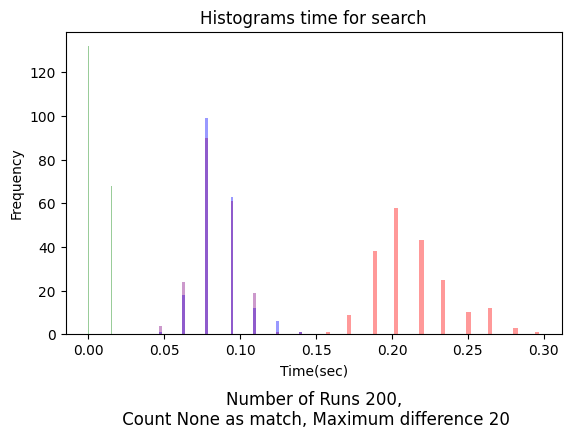

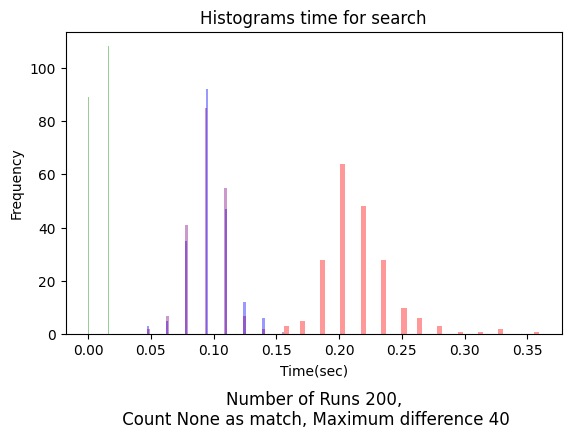

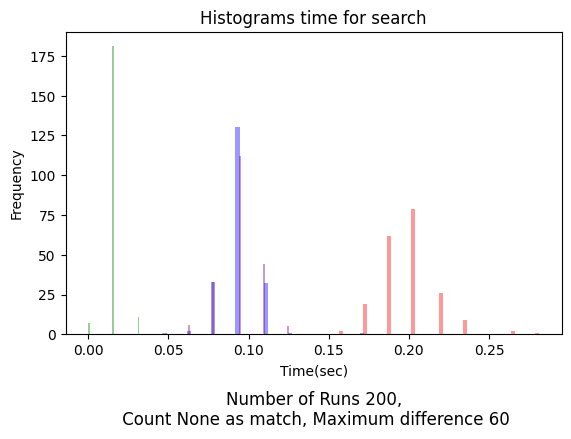

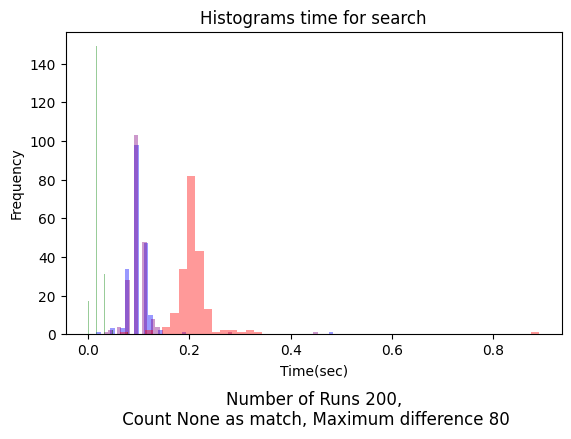

In [20]:
import matplotlib.pyplot as plt

N_test=200
missig_value="Count_None_as_match"
max_dist_list=[20,40,60,80]
for i in range(len(max_dist_list)):
    test_speed=test_speed_cgMLST_VP_tree_extion(data,test_max_dist=max_dist_list[i],N_test=N_test,method_mixing_value=missig_value)
    # Plot histograms of both lists
    plt.hist(test_speed[0][1], bins=50, alpha=0.4, label=test_speed[0][0], color='blue')
    plt.hist(test_speed[1][1], bins=50, alpha=0.4, label=test_speed[1][0], color='purple')
    plt.hist(test_speed[2][1], bins=50, alpha=0.4, label=test_speed[2][0], color='green')
    plt.hist(test_speed[3][1], bins=50, alpha=0.4, label=test_speed[3][0], color='red')
    # Add labels and title
    plt.xlabel('Time(sec)\n \n')
    plt.ylabel('Frequency')
    plt.title('Histograms time for search')
    # Add a legend
    text_string = f"Number of Runs {N_test},\n Count None as match, Maximum difference {max_dist_list[i]}"
    plt.subplots_adjust(bottom=0.25)
    plt.text(0.5, -0.30, text_string, transform=plt.gca().transAxes, 
             horizontalalignment='center', fontsize=12)

    
    plt.show()



In the above plot, a histogram of the time to find items in range, given a maximum difference, is shown. The test procedure is as follows:

First, a cgMLST sequence is drawn from the database, and each of the four methods is run. The time is recorded for each run, and this process is repeated 200 times. The times are then plotted. There are approximately 600 sequences in the database.

An advantage of running the test this way is that all methods should be penalized approximately equally by random variations in the computer's performance.

Note that the "Benchmark method" varies in performance. In my mind, it should perform the same each time since the sequence length is always the same and the method processes the entire length. However, there is still variation, which is due to the inconsistency of the test environment (my computer).

The other methods are also affected by this, but it’s harder to tell to what extent. This is because these methods' run times are influenced by other factors as well.

The "Naive method" will be affected by how similar the sequence is to others, due to early stopping.

The VP search tree is affected by whether the tree needs to search both the left and right parts of the tree.

If I had to write the code again, I would sample both the method and the max distance at random. This would break the directed acyclic graph (DAG), allowing me to understand the causal effect of setting the maximum distance.

But the main point comes across fine in the above method.



## Results for a Set Maximum Difference When None Don't Count as a Match
Below are histograms of the run times for different maximum difference settings on a dataset of approximately 600 cgMLST sequences. I have provided comments on the results and methods beneath the plots.

The range of the maximum distance is based on what I was told would be a typical search. I adjusted the maximum distance by adding 60 to the allowed difference. This value, 60, is around 5 percent of the sequence length, and I was informed that the range for missing values would typically be between 2 to 5 percent of the length.

The reason for making this adjustment is that if the maximum distance is not increased, there’s a risk that the method will not return any sequences. This is because the distance to the sequence itself would be 60 when None values don’t count as a match.


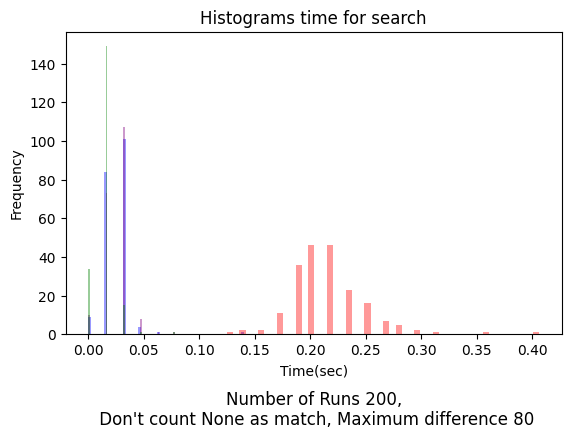

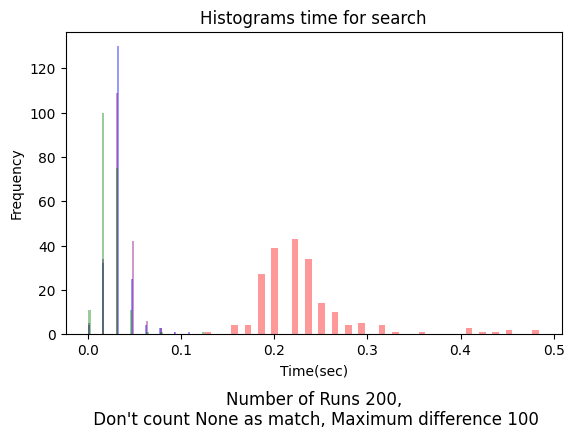

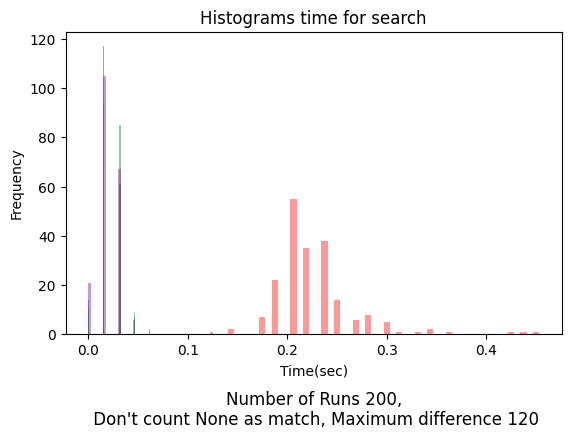

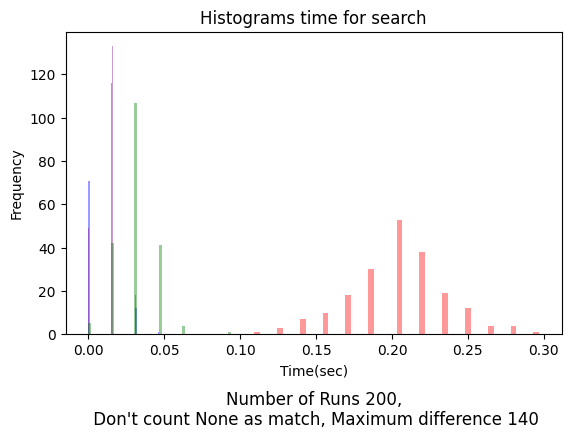

In [21]:
import matplotlib.pyplot as plt

N_test=200
missig_value="Do_not_count_None_as_match"
max_dist_list=[80,100,120,140]
for i in range(len(max_dist_list)):
    test_speed=test_speed_cgMLST_VP_tree_extion(data,test_max_dist=max_dist_list[i],N_test=N_test,method_mixing_value=missig_value)
    # Plot histograms of both lists
    plt.hist(test_speed[0][1], bins=50, alpha=0.4, label=test_speed[0][0], color='blue')
    plt.hist(test_speed[1][1], bins=50, alpha=0.4, label=test_speed[1][0], color='purple')
    plt.hist(test_speed[2][1], bins=50, alpha=0.4, label=test_speed[2][0], color='green')
    plt.hist(test_speed[3][1], bins=50, alpha=0.4, label=test_speed[3][0], color='red')
    # Add labels and title
    plt.xlabel('Time(sec)\n \n')
    plt.ylabel('Frequency')
    plt.title('Histograms time for search')
    # Add a legend
    text_string = f"Number of Runs {N_test},\n Don't count None as match, Maximum difference {max_dist_list[i]}"
    plt.subplots_adjust(bottom=0.25)
    plt.text(0.5, -0.30, text_string, transform=plt.gca().transAxes, 
             horizontalalignment='center', fontsize=12)

    
    plt.show()


Overall, the results seem consistent with those obtained when None is not counted as a match. Occasionally, when I run this code, the VP-tree outperforms the "*Naive method*". I believe this is due to the fact that the bound is much tighter when None is not counted as a match, leading to a smaller post-processing step.

This was also observed in the prototype, where the VP-tree seemed to outperform the naive method when missing values were not present.

## Looking at Mean Run Time

As long as there are no extreme outliers in the run time, it is reasonable to consider the expected run time.

Since the runs are independent, this can be approximated by the mean run time.

Below are the mean run times for a range of maximum differences allowed.

The method iterates through the list of maximum differences and finds the mean run time over 200 runs.

This corresponds to rerunning the previous section and plotting the mean. 

It should be noted that this is a new run and does not correspond to the mean of the plots above.

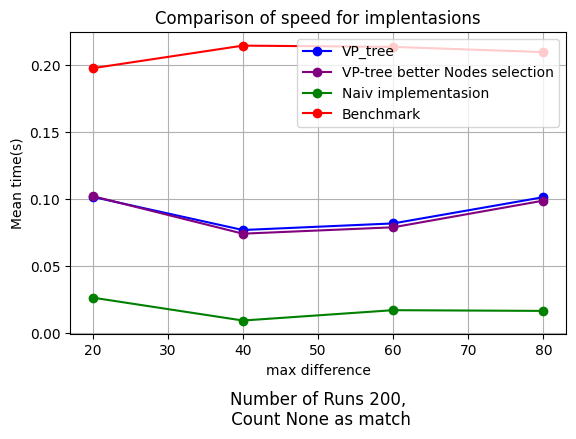

In [22]:
N_test=200
missig_value="Count_None_as_match"
max_dist_list=[20,40,60,80]
test_ob=test_speed_cgMLST_VP_tree_extion_max_dist(data,max_dist_list,N_test=N_test,method_mixing_value=missig_value)


plt.plot(max_dist_list, test_ob[1][1], marker='o', linestyle='-', color='blue', label=test_ob[1][0])
plt.plot(max_dist_list, test_ob[2][1], marker='o', linestyle='-', color='purple', label=test_ob[2][0])
plt.plot(max_dist_list, test_ob[3][1], marker='o', linestyle='-', color='green', label=test_ob[3][0])
plt.plot(max_dist_list, test_ob[4][1], marker='o', linestyle='-', color='red', label=test_ob[4][0])

# Add labels and title
plt.xlabel('max difference')
plt.ylabel('Mean time(s)')
plt.title('Comparison of speed for implentasions')

# Add a legend to identify each list
plt.legend()

text_string = f"Number of Runs {N_test},\n Count None as match"
plt.subplots_adjust(bottom=0.25)
plt.text(0.5, -0.30, text_string, transform=plt.gca().transAxes, 
             horizontalalignment='center', fontsize=12)
plt.grid(True)
# Show the plot
plt.show()



In [ ]:
N_test=200
missig_value="Do_not_count_None_as_match"
max_dist_list=[80,100,120,140]
#Max_dist_list=[140,120,100,80]

test_ob=test_speed_cgMLST_VP_tree_extion_max_dist(data,max_dist_list,N_test=200,method_mixing_value=missig_value)


plt.plot(max_dist_list, test_ob[1][1], marker='o', linestyle='-', color='blue', label=test_ob[1][0])
plt.plot(max_dist_list, test_ob[2][1], marker='o', linestyle='-', color='purple', label=test_ob[2][0])
plt.plot(max_dist_list, test_ob[3][1], marker='o', linestyle='-', color='green', label=test_ob[3][0])
plt.plot(max_dist_list, test_ob[4][1], marker='o', linestyle='-', color='red', label=test_ob[4][0])

# Add labels and title
plt.xlabel('max difference')
plt.ylabel('Mean time(s)')
plt.title('Comparison of speed for implentasions')

# Add a legend to identify each list
plt.legend()

text_string = f"Number of Runs {N_test},\n Don't count None as match"
plt.subplots_adjust(bottom=0.25)
plt.text(0.5, -0.30, text_string, transform=plt.gca().transAxes, 
             horizontalalignment='center', fontsize=12)

plt.grid(True)

# Show the plot
plt.show()

From the mean, it is clear that for this database size, when None is counted as a match, the VP-tree method is outperformed by the "*Naive method*".

When None is not counted as a match, the two implementations seem to have similar performance. This makes sense since the bound is tighter when None is not counted as a match.

I would suspect that as the data size grows, the VP-tree method would outperform the *"Naive method*".

# Discussion

From my testing, it seems that a larger maximum difference does not lead to a longer runtime with early stopping and VP search. This should not be the case. I believe the reason is that I'm running tests in seconds, and other processes are running on my PC at the same time, meaning the test environment is not consistent.

The testing I can do is fairly limited due to the data I have available. The runtime of the naive method will be affected by how different the values in the database are. Since I don't have access to the full data, I can't make any definitive judgments, and because I don't have a clear idea of realistic settings for the simulation function, I'm at a loss.

The good news is that this is possible for SSI. They can take my tests, input the data, and see if they achieve an improvement in performance.

I would expect my implementation to show further improvement if the size of the database grows. However, due to the added complexity of maintaining the data structure, I would not implement this method unless a sufficiently large improvement is demonstrated.

# Conclusion
The adapted VP search works effectively, producing the correct output and showing an improvement in speed compared to the Benchmark method. However, the comparison with the Naive method is less clear. I suspect that this new method would outperform the Naive method as the data in the database grows.

Whether it is worth implementing in the SSI environment would depend on their assessment.